In [1]:
import xml.etree.ElementTree as ET 
import gzip
from xml.etree.cElementTree import ElementTree

import pandas as pd
import geopandas as gpd
import timeit
import geopy.distance
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from shapely.geometry import Point, MultiPoint, Polygon
import random
from pyproj import Proj, transform #Convertion EPSG2154 to WGS84

from datetime import datetime

import statistics
from collections import defaultdict 

import matsim

In [2]:
## Adapted from Théo's code

def parse_attributes(node):
    values=[subnode.text for subnode in node.findall("attribute")]
    attributes=[subnode.attrib["name"] for subnode in node.findall("attribute")]
    person=dict()
    for ii in range(len(values)):
        person[attributes[ii]]=values[ii]
    if person!=[None]:
        return(person)
    
def parse_person(node):
    person = parse_attributes(node.find("attributes"))
    person["id"] = node.attrib["id"]
    return(person)

def parse_plan(node):
    children = list(node)
    plan={"selected":node.attrib["selected"]=="yes","activities":[{**{"activityType":child.tag}, **child.attrib} for child in children]}
    return plan

def parse_person_plan(node):
    # on récupère les plans sélectionnés
    plans = [parse_plan(plan) for plan in node.findall("plan") if plan.attrib["selected"]=="yes"]
    personId = node.attrib["id"]
    if len(plans)!=1:
        raise Exception("La personne d'id "+str(personId)+" a plusieurs plans sélectionnés !")
    else:
        plan={"personId":personId,"activities":plans[0]["activities"]}
        return(plan)

def parse_population(path):
    with gzip.open(initialPlanFile,'r') as fichier:
        tree = ET.ElementTree()
        tree.parse (fichier)
        population = tree.getroot()
        return [parse_person(node) for node in population.findall("person")]
    
def parse_plans_population(path):
    with gzip.open(initialPlanFile,'r') as fichier:
        tree = ET.ElementTree()
        tree.parse (fichier)
        population = tree.getroot()
        return [parse_person_plan(node) for node in population.findall("person")]

def select_first_coordinate_in_plan(person_plan):
    """A partir du plan d'une personne, remonte à ces premières coordonnées
    Renvoie un dict {personId,x,y}"""
    plan=person_plan["activities"]
    coordinates_found=False
    first_coordinates={"personId":person_plan["personId"]}
    for acti in plan:
        if "x" in acti:
            coordinates_found=True
            first_coordinates["x"]=acti["x"]
            first_coordinates["y"]=acti["y"]
            break
    if not coordinates_found:
        raise Exception("La personne "+str(person_plan["personId"])+" n'a pas de coordonnées définissables avec son plan d'activité.")
    else:
        return(first_coordinates)

def first_person_coordinates(path):
    with open(path, 'r') as fichier:
        tree = ET.ElementTree()
        tree.parse (fichier)
        population = tree.getroot()
        first_coordinates=[select_first_coordinate_in_plan(parse_person_plan(node)) for node in population.findall("person")]
        return(first_coordinates)

def population_stats(population):
    number=len(population)
    print("Taille population:   ",number)
    print("Titulaires du permis:",len([person for person in population if person["hasLicense"]=="yes"]))
    print("Femmes:              ",len([person for person in population if person["sex"]=="f"]))
    print("Hommes:              ",len([person for person in population if person["sex"]=="m"]))
    print("Revenu moyen:        ",statistics.mean([float(person["householdIncome"]) for person in population]))
    print("Abonnés aux pt:      ",len([person for person in population if person["hasPtSubscription"].lower()=="true"]))
    #return members
    #CSMembership(members,companies,CSMembership_file

In [3]:
def convert_time(x):
    return np.dot(np.array(x.split(":"), dtype = float), [3600.0, 60.0])

def convert_time_h_m_s(x):
    return np.dot(np.array(x.split(":"), dtype = float), [3600.0, 60.0, 1.0])

In [4]:
output_path_300_ite = "/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/scenario1_c3" 
output_path = "/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/scenario1_1000_ite" 

## Scenario description : Private autonomous vehicle (PAV)
- Remplacement des voitures privées dans les menages motorisés par des robotaxis. 
- Allocation d'un vehicule autonome privé (PAV) aux menages concernés
- Tous les déplacements en voiture doivent se faire avec le seul PAV

In [5]:
input_trips_file = "%s/df_trips_input_plans.csv" %output_path_300_ite
input_persons_file = "%s/df_persons_input_perons.csv" %output_path_300_ite
df_persons_input = pd.read_csv(input_persons_file)
df_trips_input = pd.read_csv(input_trips_file)

In [6]:
df_persons_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63170 entries, 0 to 63169
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         63170 non-null  int64  
 1   age                63170 non-null  int64  
 2   bikeAvailability   63170 non-null  object 
 3   carAvailability    63170 non-null  object 
 4   censusHouseholdId  63170 non-null  int64  
 5   censusPersonId     63170 non-null  int64  
 6   employed           63170 non-null  bool   
 7   hasLicense         63170 non-null  object 
 8   hasPtSubscription  63170 non-null  bool   
 9   householdId        63170 non-null  int64  
 10  householdIncome    63170 non-null  float64
 11  htsHouseholdId     63170 non-null  int64  
 12  htsPersonId        63170 non-null  int64  
 13  isPassenger        63170 non-null  bool   
 14  sex                63170 non-null  object 
 15  subpopulation      63170 non-null  object 
 16  person_id          631

In [7]:
df_trips_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354575 entries, 0 to 354574
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    354575 non-null  int64  
 1   person_id                     354575 non-null  int64  
 2   departure_time                354575 non-null  object 
 3   arrival_time                  354575 non-null  object 
 4   mode                          354575 non-null  object 
 5   preceding_purpose             354575 non-null  object 
 6   from_x                        354575 non-null  float64
 7   from_y                        354575 non-null  float64
 8   preceding_purpose_start_time  167835 non-null  object 
 9   preceding_purpose_end_time    231005 non-null  object 
 10  following_purpose             354575 non-null  object 
 11  to_x                          354575 non-null  float64
 12  to_y                          354575 non-nul

In [8]:
df_trips_input

,Unnamed: 0,person_id,departure_time,arrival_time,mode,preceding_purpose,from_x,from_y,preceding_purpose_start_time,preceding_purpose_end_time,following_purpose,to_x,to_y,following_purpose_start_time,following_purpose_end_time,is_first,is_last
0,0,1000008,07:03:47,07:13:47,private_AV,home,844783.995555,6.519932e+06,NaN,07:03:47,other,842728.100000,6.519167e+06,07:13:47,07:13:47,True,False
1,1,1000008,07:13:47,07:58:47,private_AV,other,842728.100000,6.519167e+06,07:13:47,07:13:47,work,841768.160000,6.511899e+06,07:58:47,12:03:47,False,False
2,2,1000008,12:03:47,12:13:47,walk,work,841768.160000,6.511899e+06,07:58:47,12:03:47,leisure,841455.790000,6.511423e+06,12:13:47,12:33:47,False,False
3,3,1000008,12:33:47,12:43:47,walk,leisure,841455.790000,6.511423e+06,12:13:47,12:33:47,work,841768.160000,6.511899e+06,12:43:47,17:33:47,False,False
4,4,1000008,17:33:47,18:18:47,private_AV,work,841768.160000,6.511899e+06,12:43:47,17:33:47,home,844783.995555,6.519932e+06,18:18:47,19:28:47,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354570,354570,999994,07:05:31,07:15:31,private_AV,other,847968.600000,6.518541e+06,07:05:31,07:05:31,education,847319.700000,6.519014e+06,07:15:31,16:15:31,False,False
354571,354571,999994,16:15:31,16:45:31,private_AV,education,847319.700000,6.519014e+06,07:15:31,16:15:31,home,854492.550000,6.521136e+06,16:45:31,NaN,False,True
354572,354572,999995,07:13:37,07:48:37,private_AV,home,854492.550000,6.521136e+06,NaN,07:13:37,education,857259.400000,6.521244e+06,07:48:37,11:28:37,True,False
354573,354573,999995,11:28:37,12:13:37,private_AV,education,857259.400000,6.521244e+06,07:48:37,11:28:37,home,854492.550000,6.521136e+06,12:13:37,18:28:37,False,False


In [9]:
df_count_trips = df_trips_input[["person_id"]].groupby("person_id").size().reset_index(name = "number_of_trips")

In [10]:
df_persons_input = pd.merge(df_persons_input, df_count_trips, on = "person_id", how = "left")

In [11]:
df_count_persons = df_persons_input[["householdId"]].groupby("householdId").size().reset_index(name = "number_of_persons")

In [12]:
df_persons_input = pd.merge(df_persons_input, df_count_persons, on = "householdId", how = "left")

In [13]:
df_persons_input

,Unnamed: 0,age,bikeAvailability,carAvailability,censusHouseholdId,censusPersonId,employed,hasLicense,hasPtSubscription,householdId,householdIncome,htsHouseholdId,htsPersonId,isPassenger,sex,subpopulation,person_id,number_of_trips,number_of_persons
0,0,32,none,none,183012,377986,True,yes,False,474430,4476.391583,8484,18514,False,m,private,1000008,7,3
1,1,32,all,none,183012,377986,True,yes,False,474430,4476.391583,1537,3356,False,m,private,1000009,4,3
2,2,32,some,none,183012,377986,True,yes,False,474430,4476.391583,4923,10846,True,m,private,1000010,11,3
3,3,33,none,none,18480,38075,False,yes,True,47644,2083.709401,8999,19603,False,m,private,100002,11,3
4,4,33,all,none,18480,38075,False,yes,False,47644,2083.709401,1830,3991,False,m,private,100003,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63165,63165,66,none,none,182997,377959,True,yes,False,474396,3022.192917,680,1540,False,f,private,999947,6,2
63166,63166,25,none,none,183008,377980,False,yes,False,474420,4924.560292,535,1230,False,m,private,999992,2,4
63167,63167,25,none,none,183008,377980,False,no,True,474420,4924.560292,7535,16468,False,m,private,999993,6,4
63168,63168,23,none,none,183008,377981,False,yes,False,474420,4924.560292,3375,7270,False,f,private,999994,3,4


In [14]:
df_private_persons_input = df_persons_input[df_persons_input["subpopulation"]=="private"]

In [15]:
len(df_private_persons_input["householdId"].unique())

20510

In [16]:
df_private_persons_input["number_of_persons"].describe()

count    48272.000000
mean         3.137720
std          1.536437
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         13.000000
Name: number_of_persons, dtype: float64

In [17]:
df_private_persons_input

,Unnamed: 0,age,bikeAvailability,carAvailability,censusHouseholdId,censusPersonId,employed,hasLicense,hasPtSubscription,householdId,householdIncome,htsHouseholdId,htsPersonId,isPassenger,sex,subpopulation,person_id,number_of_trips,number_of_persons
0,0,32,none,none,183012,377986,True,yes,False,474430,4476.391583,8484,18514,False,m,private,1000008,7,3
1,1,32,all,none,183012,377986,True,yes,False,474430,4476.391583,1537,3356,False,m,private,1000009,4,3
2,2,32,some,none,183012,377986,True,yes,False,474430,4476.391583,4923,10846,True,m,private,1000010,11,3
3,3,33,none,none,18480,38075,False,yes,True,47644,2083.709401,8999,19603,False,m,private,100002,11,3
4,4,33,all,none,18480,38075,False,yes,False,47644,2083.709401,1830,3991,False,m,private,100003,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63165,63165,66,none,none,182997,377959,True,yes,False,474396,3022.192917,680,1540,False,f,private,999947,6,2
63166,63166,25,none,none,183008,377980,False,yes,False,474420,4924.560292,535,1230,False,m,private,999992,2,4
63167,63167,25,none,none,183008,377980,False,no,True,474420,4924.560292,7535,16468,False,m,private,999993,6,4
63168,63168,23,none,none,183008,377981,False,yes,False,474420,4924.560292,3375,7270,False,f,private,999994,3,4


In [18]:
df_count_private_persons = df_private_persons_input[["householdId"]].groupby("householdId").size().reset_index(name = "number_of_persons")

In [19]:
count_private_persons = df_count_private_persons["number_of_persons"].value_counts(normalize=True) * 100

In [20]:
count_private_persons

2     32.857143
1     32.096538
3     14.236958
4     12.657240
5      5.602145
6      1.911263
7      0.458313
8      0.131643
9      0.039005
13     0.004876
11     0.004876
Name: number_of_persons, dtype: float64

<AxesSubplot:>

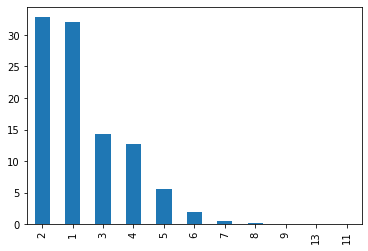

In [21]:
count_private_persons.plot(kind="bar")

In [22]:
df_private_persons_input["number_of_trips"].describe()

count    48272.000000
mean         5.271524
std          3.796943
min          1.000000
25%          2.000000
50%          4.000000
75%          6.000000
max         43.000000
Name: number_of_trips, dtype: float64

In [23]:
count_trips = df_private_persons_input["number_of_trips"].value_counts(normalize=True) * 100

In [24]:
count_trips

2     28.536211
4     21.762098
6     11.265330
3      7.354160
5      6.036626
8      5.883328
10     4.089327
7      3.521710
12     2.626782
9      1.796072
14     1.528837
11     1.236742
16     0.959148
13     0.749917
15     0.482681
18     0.466109
1      0.416390
17     0.321097
20     0.292095
19     0.159513
22     0.118081
21     0.109794
24     0.076649
23     0.055933
26     0.051790
25     0.020716
27     0.018644
28     0.016573
34     0.010358
30     0.010358
31     0.006215
29     0.004143
32     0.004143
35     0.004143
33     0.004143
36     0.002072
43     0.002072
Name: number_of_trips, dtype: float64

<AxesSubplot:>

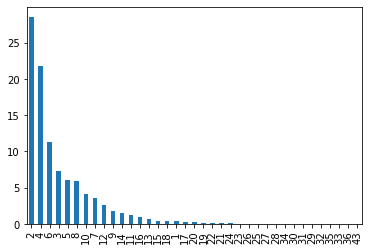

In [25]:
count_trips.plot(kind="bar")

### parts modales (input)

To do : check the modal before PAV integration

In [26]:
modal_share_inp = df_trips_input["mode"].value_counts(normalize=True) * 100

In [27]:
modal_share_inp

walk          58.707185
private_AV    22.475076
pt            17.425086
bike           1.392653
Name: mode, dtype: float64

Text(0.5, 0, 'Mode de transport')

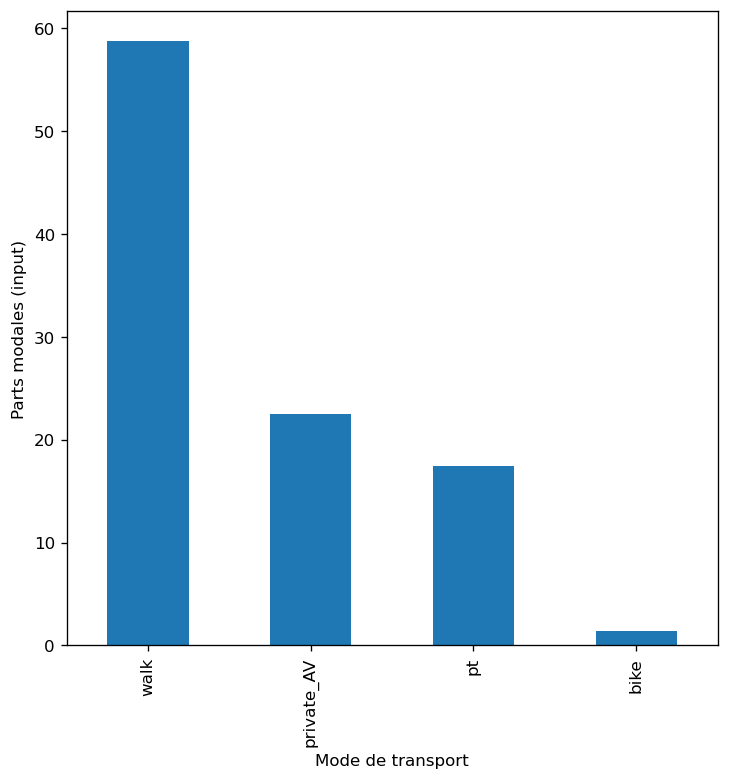

In [28]:
plt.figure(figsize = (7, 7), dpi = 120)
modal_share_inp.plot(kind="bar")
plt.ylabel("Parts modales (input)")
plt.xlabel("Mode de transport")

In [29]:
time_class = np.arange(0, 26) * 3600

In [30]:
df_trips_input["dep_time_in_s"] = df_trips_input["departure_time"].apply(convert_time_h_m_s).astype(float)

In [31]:
df_trips_input["dep_time_class"] = np.digitize(df_trips_input["dep_time_in_s"], time_class)

In [32]:
df_trips_input["dep_time_in_s"].describe()

count    354575.000000
mean      49093.559368
std       15623.001536
min       12722.000000
25%       34109.000000
50%       49803.000000
75%       62093.500000
max      101558.000000
Name: dep_time_in_s, dtype: float64

In [33]:
df_trips_input.loc[df_trips_input["dep_time_class"]==24, "dep_time_class"] = 0
df_trips_input.loc[df_trips_input["dep_time_class"]==25, "dep_time_class"] = 1
df_trips_input.loc[df_trips_input["dep_time_class"]==26, "dep_time_class"] = 2

In [34]:
f_pav = df_trips_input["mode"] == "private_AV"

In [35]:
df_trips_input_pav = df_trips_input[f_pav]

In [36]:
print("Nombre total de déplacements en PAV : ", len(df_trips_input_pav) * 20)

Nombre total de déplacements en PAV :  1593820


In [37]:
df_pond = pd.concat([df_trips_input_pav]*20, ignore_index=True)
df_pond

,Unnamed: 0,person_id,departure_time,arrival_time,mode,preceding_purpose,from_x,from_y,preceding_purpose_start_time,preceding_purpose_end_time,following_purpose,to_x,to_y,following_purpose_start_time,following_purpose_end_time,is_first,is_last,dep_time_in_s,dep_time_class
0,0,1000008,07:03:47,07:13:47,private_AV,home,844783.995555,6.519932e+06,NaN,07:03:47,other,842728.100000,6.519167e+06,07:13:47,07:13:47,True,False,25427.0,8
1,1,1000008,07:13:47,07:58:47,private_AV,other,842728.100000,6.519167e+06,07:13:47,07:13:47,work,841768.160000,6.511899e+06,07:58:47,12:03:47,False,False,26027.0,8
2,4,1000008,17:33:47,18:18:47,private_AV,work,841768.160000,6.511899e+06,12:43:47,17:33:47,home,844783.995555,6.519932e+06,18:18:47,19:28:47,False,False,63227.0,18
3,5,1000008,19:28:47,19:38:47,private_AV,home,844783.995555,6.519932e+06,18:18:47,19:28:47,other,842067.600000,6.518710e+06,19:38:47,19:43:47,False,False,70127.0,20
4,6,1000008,19:43:47,19:53:47,private_AV,other,842067.600000,6.518710e+06,19:38:47,19:43:47,home,844783.995555,6.519932e+06,19:53:47,NaN,False,True,71027.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1593815,354569,999994,06:45:31,07:05:31,private_AV,home,854492.550000,6.521136e+06,NaN,06:45:31,other,847968.600000,6.518541e+06,07:05:31,07:05:31,True,False,24331.0,7
1593816,354570,999994,07:05:31,07:15:31,private_AV,other,847968.600000,6.518541e+06,07:05:31,07:05:31,education,847319.700000,6.519014e+06,07:15:31,16:15:31,False,False,25531.0,8
1593817,354571,999994,16:15:31,16:45:31,private_AV,education,847319.700000,6.519014e+06,07:15:31,16:15:31,home,854492.550000,6.521136e+06,16:45:31,NaN,False,True,58531.0,17
1593818,354572,999995,07:13:37,07:48:37,private_AV,home,854492.550000,6.521136e+06,NaN,07:13:37,education,857259.400000,6.521244e+06,07:48:37,11:28:37,True,False,26017.0,8


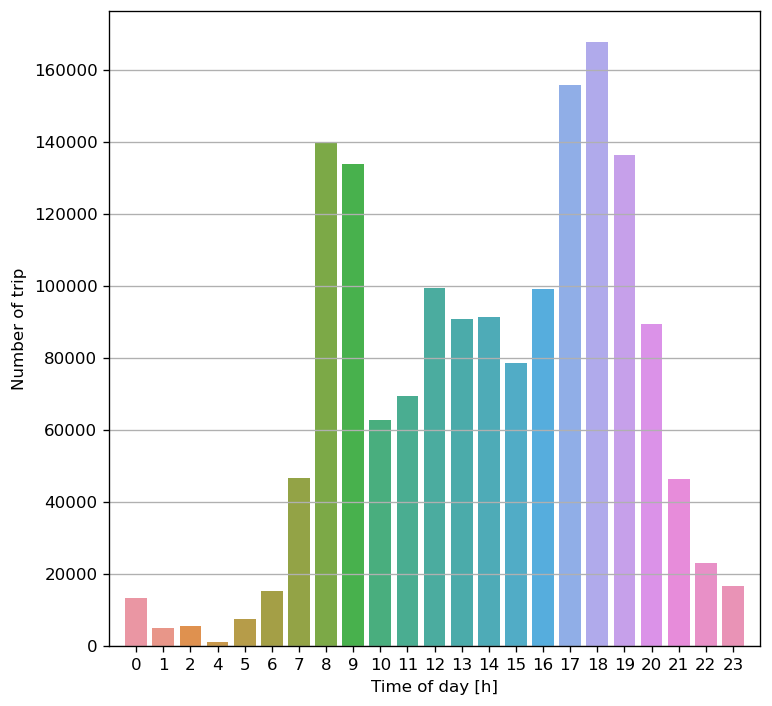

In [38]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="dep_time_class", data=df_pond)
ax.grid(axis='y')
plt.xlim([-1, 23])
plt.ylabel("Number of trip")
plt.xlabel("Time of day [h]")
plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc1/pav_trip_distribution_sce1_weighted.pdf', bbox_inches="tight")

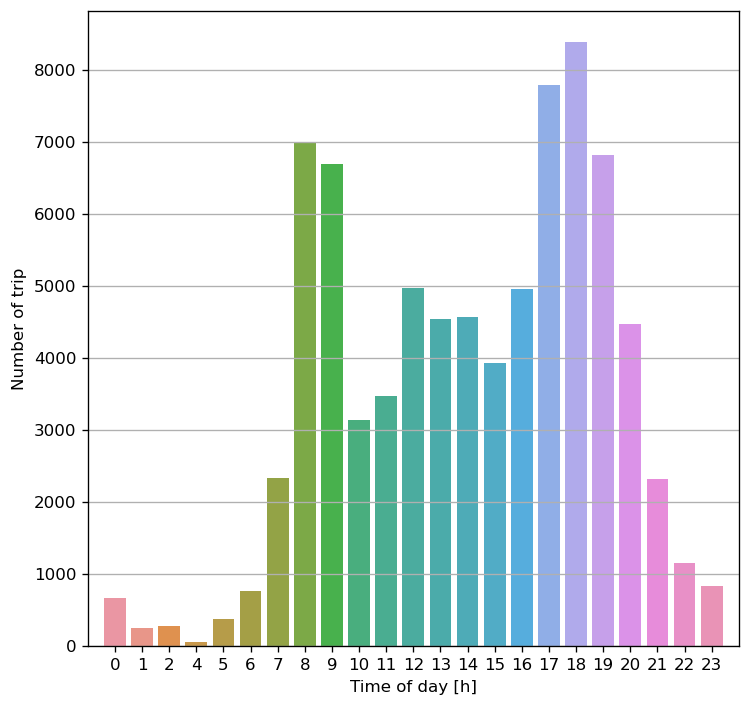

In [39]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="dep_time_class", data=df_trips_input_pav)
ax.grid(axis='y')
plt.xlim([-1, 23])
plt.ylabel("Number of trip")
plt.xlabel("Time of day [h]")
plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc1/pav_trip_distribution_sce1.pdf', bbox_inches="tight")

In [40]:
df_trips_input_pav["dep_time_class"].value_counts()

18    8392
17    7789
8     6984
19    6815
9     6690
12    4976
16    4956
14    4569
13    4542
20    4474
15    3922
11    3467
10    3131
7     2332
21    2319
22    1142
23     835
6      759
0      657
5      373
2      268
1      242
4       57
Name: dep_time_class, dtype: int64

In [41]:
count_trips_pav_h = df_trips_input_pav["dep_time_class"].value_counts(normalize=True) * 100

In [42]:
count_trips_pav_h

18    10.530675
17     9.774002
8      8.763850
19     8.551781
9      8.394925
12     6.244118
16     6.219021
14     5.733395
13     5.699514
20     5.614185
15     4.921509
11     4.350554
10     3.928925
7      2.926303
21     2.909990
22     1.433035
23     1.047797
6      0.952429
0      0.824434
5      0.468058
2      0.336299
1      0.303673
4      0.071526
Name: dep_time_class, dtype: float64

Text(0.5, 0, 'Trip purposes')

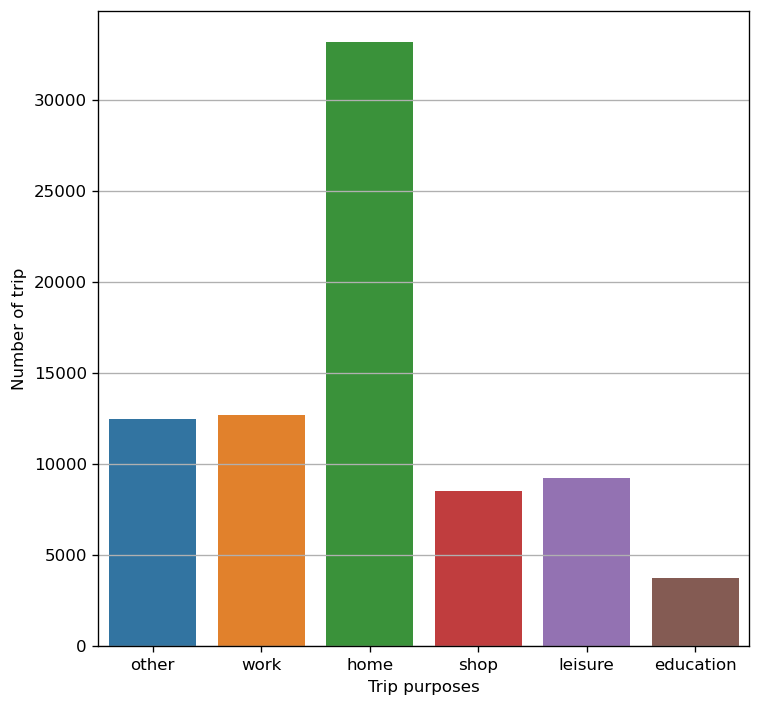

In [43]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="following_purpose", data=df_trips_input_pav)
ax.grid(axis='y')
plt.ylabel("Number of trip")
plt.xlabel("Trip purposes")

In [44]:
f_matin = df_trips_input_pav["dep_time_class"] == 8
f_matin |= df_trips_input_pav["dep_time_class"] == 9

f_midi = df_trips_input_pav["dep_time_class"] == 12
f_midi |= df_trips_input_pav["dep_time_class"] == 13
f_midi |= df_trips_input_pav["dep_time_class"] == 14

f_soir = df_trips_input_pav["dep_time_class"] == 17
f_soir |= df_trips_input_pav["dep_time_class"] == 18
f_soir |= df_trips_input_pav["dep_time_class"] == 19

Text(0.5, 0, 'Trip purposes from 8h to 9h')

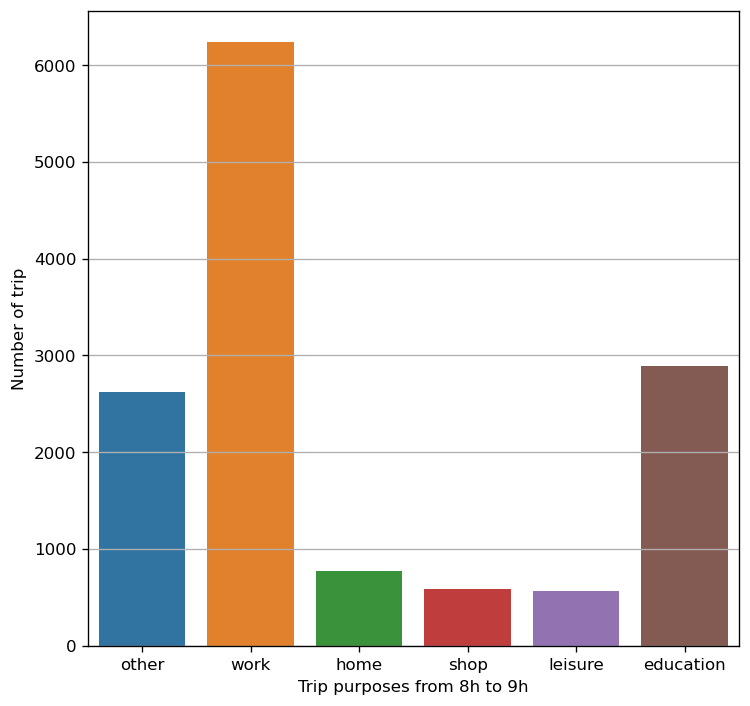

In [45]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="following_purpose", data=df_trips_input_pav[f_matin])
ax.grid(axis='y')
plt.ylabel("Number of trip")
plt.xlabel("Trip purposes from 8h to 9h")

In [46]:
df_trips_input_pav[f_matin]["following_purpose"].value_counts(normalize=True) * 100

work         45.655989
education    21.113061
other        19.197016
home          5.667691
shop          4.248940
leisure       4.117303
Name: following_purpose, dtype: float64

Text(0.5, 0, 'Trip purposes from 12h to 14h')

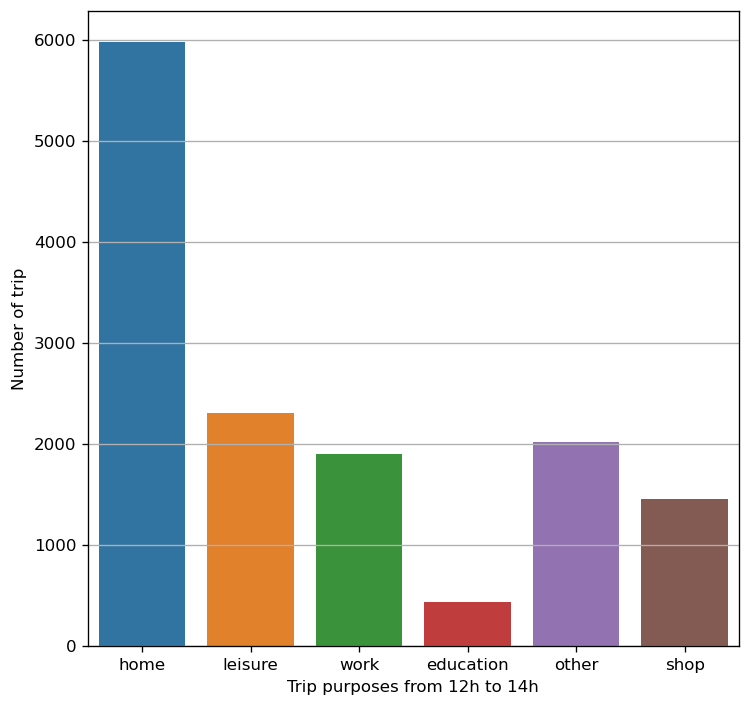

In [47]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="following_purpose", data=df_trips_input_pav[f_midi])
ax.grid(axis='y')
plt.ylabel("Number of trip")
plt.xlabel("Trip purposes from 12h to 14h")

In [48]:
df_trips_input_pav[f_midi]["following_purpose"].value_counts(normalize=True) * 100

home         42.464684
leisure      16.341308
other        14.318166
work         13.508909
shop         10.321573
education     3.045361
Name: following_purpose, dtype: float64

Text(0.5, 0, 'Trip purposes from 17h to 19h')

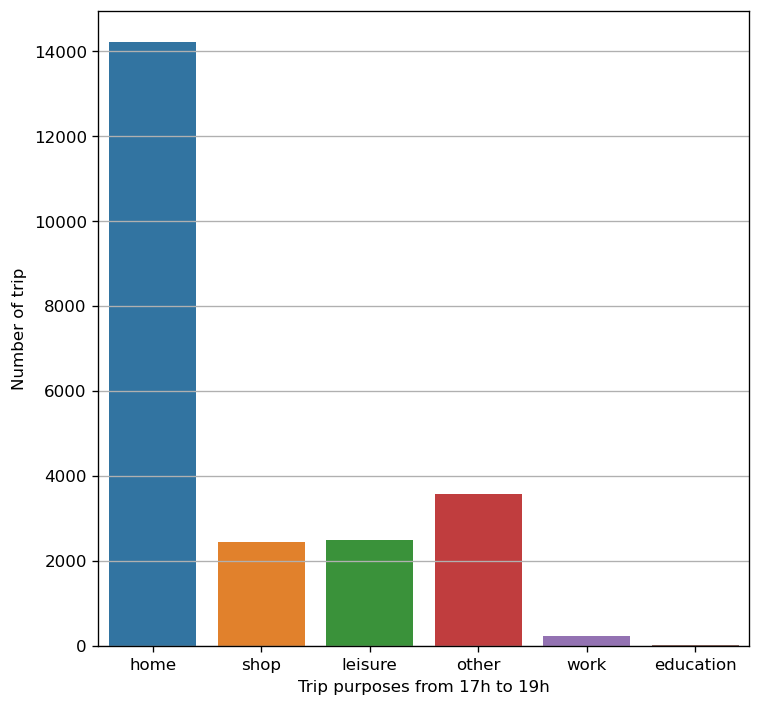

In [49]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="following_purpose", data=df_trips_input_pav[f_soir])
ax.grid(axis='y')
plt.ylabel("Number of trip")
plt.xlabel("Trip purposes from 17h to 19h")

In [50]:
df_trips_input_pav[f_soir]["following_purpose"].value_counts(normalize=True) * 100

home         61.849887
other        15.576622
leisure      10.806227
shop         10.645330
work          1.021917
education     0.100017
Name: following_purpose, dtype: float64

In [51]:
'''
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="dep_time_class", hue="following_purpose", data=df_trips_input_taxi)
ax.grid(axis='y')
plt.ylabel("Taxi flow input (input population)")
plt.xlabel("Trip purposes over the day")
'''

'\nplt.figure(figsize = (7, 7), dpi = 120)\nax = sns.countplot(x="dep_time_class", hue="following_purpose", data=df_trips_input_taxi)\nax.grid(axis=\'y\')\nplt.ylabel("Taxi flow input (input population)")\nplt.xlabel("Trip purposes over the day")\n'

## Description de la population

- $\mathbf{5\%}$ de la population réelle ($\mathbf{30900}$ ménages /$\mathbf{63 110}$ ind. / $\mathbf{310 000}$ dép.)
- $\mathbf{20510}$ menages pour $\mathbf{48259}$ personnes concernées par les déplacements en PAV. Donc, il y a $\mathbf{20510}$ PAV pour $\mathbf{79691}$ déplacements (soit $\mathbf{25,7\%}$ des déplacements toal) à realiser toute la journée.
- $\mathbf{32\%}$, $\mathbf{33\%}$, $\mathbf{14,2\%}$,  $\mathbf{12,6\%}$ et $\mathbf{5,6\%}$ des menages motorisés sont composés respectivement de $\mathbf{1}$, $\mathbf{2}$, $\mathbf{3}$, $\mathbf{4}$ et $\mathbf{5}$ personnes.
- En **moyenne** les menages motorisés sont composés de **trois personnes**.
- **Une personne** dans un menage motorisé realise en **moyenne cinq déplacements par jour**.
- $\mathbf{28,5\%}$, $\mathbf{21,8\%}$, $\mathbf{11,3\%}$ des personnes dans un menage motorisé effectuent respectivement $\mathbf{2}$, $\mathbf{4}$ et $\mathbf{6}$ déplacements par jour. 
- La majeure partie des déplacements en PAV est réalisée durant les heures de pointe du matin (8h-9h) pour la réalisation des activités quotidiennes (travail et éducation) et du soir (17h-19h) pour le retour au domicile avec respectivement $\mathbf{17,15\%}$ (soit $\mathbf{13674}$) et $\mathbf{28,85\%}$ (soit $\mathbf{22996}$) des déplacements. On note également un pic moyen entre 12h et 14h pour $\mathbf{17,66}$ ($\mathbf{14087}$) des déplacements correspondant principalement au **retour au domicile**.

## Configuration de la simulation

- $\mathbf{1300}$ itérations / simulation (arret de l'innovation à $\mathbf{80\%}$)
- Strategies de re-planification :
    - $\mathbf{5}$ plans max / agent
    - Chaque agent change, avec une probalité de $\mathbf{5\%}$, son itinéraire et le planning de ses activités (heure de fin). La probabilité du changement du mode de transport a été fixée à $\mathbf{10\%}$ pour accelerer la convergernce de la simulation.
    - Le changement de modes de transport pour les agents motorisés concerne uniquement les TC, le PAV, le vélo, et la marche à pied. Pour les agents non motorisés, le choix se fait entre les TC, le vélo, et la marche à pied.
    - Chaque agent choisi un plan parmi les 5 selon un modèle logit avec une probalité de $\mathbf{80\%}$.

## Analyse des resultats de la simulation

In [52]:
##Case 1 : with 20510 PAV
task_time_profiles_pav_file = "%s/ITERS/it.1300/sce1.1000_ite.1300.task_time_profiles_private_AV.txt" %output_path
df_task_time_profiles_pav = pd.read_csv(task_time_profiles_pav_file, sep="	")

In [53]:
df_task_time_profiles_pav

,time,DROPOFF,EMPTY_DRIVE,OCCUPIED_DRIVE,PICKUP,STAY
0,00:00,0.0,0.0,0.0,0.0,20510.0
1,00:05,0.0,0.0,0.0,0.0,20510.0
2,00:10,0.0,0.0,0.0,0.0,20510.0
3,00:15,0.0,0.0,0.0,0.0,20510.0
4,00:20,0.0,0.0,0.0,0.0,20510.0
...,...,...,...,...,...,...
356,29:40,0.0,0.0,0.0,0.0,0.0
357,29:45,0.0,0.0,0.0,0.0,0.0
358,29:50,0.0,0.0,0.0,0.0,0.0
359,29:55,0.0,0.0,0.0,0.0,0.0


In [54]:
df_task_time_profiles_pav["time_in_s"] = df_task_time_profiles_pav["time"].apply(convert_time).astype(float)

In [55]:
df_task_time_profiles_pav["time_class"] = np.digitize(df_task_time_profiles_pav["time_in_s"], time_class)

In [56]:
hours = ["00:00","01:00","02:00","03:00","04:00","05:00","06:00","07:00","08:00","09:00","10:00","11:00", 
        "12:00","13:00","14:00","15:00","16:00","17:00","18:00","19:00","20:00","21:00","22:00","23:00","24:00",
        "25:00","26:00","27:00","28:00","29:00","30:00"]

In [57]:
df_task_time_profiles_pav["BUSY"] = df_task_time_profiles_pav["PICKUP"] + df_task_time_profiles_pav["DROPOFF"] + df_task_time_profiles_pav["EMPTY_DRIVE"] + df_task_time_profiles_pav["OCCUPIED_DRIVE"]

In [58]:
#df_task_time_profiles_pav.groupby(["time_class"])["BUSY"].sum().reset_index(name = "BUSY")

In [59]:
#df_task_time_profiles = df_task_time_profiles_pav.groupby(["time_class"])["DROPOFF", "EMPTY_DRIVE", "BUSY", "OCCUPIED_DRIVE", "PICKUP"].sum().reset_index()

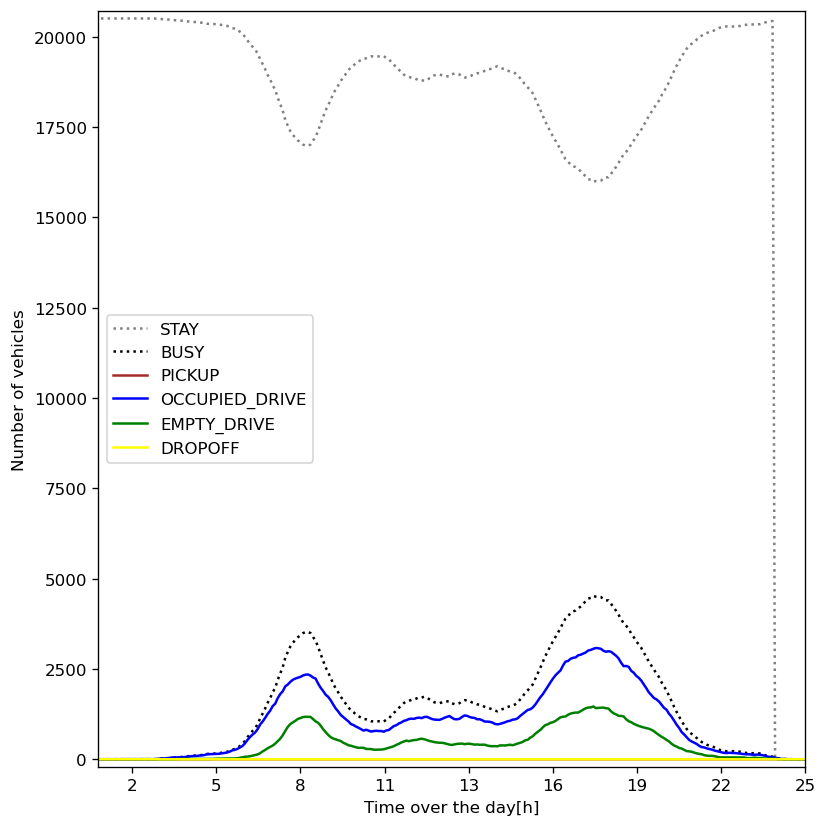

Fig. 1: Vehicle operations over the whole day


In [60]:
plt.figure(figsize = (7, 7), dpi = 120)

plt.plot(df_task_time_profiles_pav["time_in_s"], df_task_time_profiles_pav["STAY"], color = "gray", label = "STAY" , linestyle = ":")
plt.plot(df_task_time_profiles_pav["time_in_s"], df_task_time_profiles_pav["BUSY"], color = "black", label = "BUSY" , linestyle = ":")
plt.plot(df_task_time_profiles_pav["time_in_s"], df_task_time_profiles_pav["PICKUP"], color = "brown", label = "PICKUP")
plt.plot(df_task_time_profiles_pav["time_in_s"], df_task_time_profiles_pav["OCCUPIED_DRIVE"], color = "blue", label = "OCCUPIED_DRIVE")
plt.plot(df_task_time_profiles_pav["time_in_s"], df_task_time_profiles_pav["EMPTY_DRIVE"], color = "green", label = "EMPTY_DRIVE")
plt.plot(df_task_time_profiles_pav["time_in_s"], df_task_time_profiles_pav["DROPOFF"], color = "yellow", label = "DROPOFF")

plt.xlabel("Time over the day[h]")
plt.ylabel("Number of vehicles")

plt.gca().xaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x/3600)
))

#plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([6000, 90000])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc1/task_time_profiles_Line_pav_sc1.pdf', bbox_inches="tight")
plt.close()
print("Fig. 1: Vehicle operations over the whole day")

In [61]:
#plt.figure(figsize = (7, 7), dpi = 120)

#plt.plot(df_task_time_profiles["time_class"], df_task_time_profiles["STAY"], color = "gray", label = "STAY" , linestyle = ":")
#plt.plot(df_task_time_profiles["time_class"], df_task_time_profiles["BUSY"], color = "black", label = "BUSY" , linestyle = ":")
#plt.plot(df_task_time_profiles["time_class"], df_task_time_profiles["PICKUP"], color = "brown", label = "PICKUP")
#plt.plot(df_task_time_profiles["time_class"], df_task_time_profiles["OCCUPIED_DRIVE"], color = "blue", label = "OCCUPIED_DRIVE")
#plt.plot(df_task_time_profiles["time_class"], df_task_time_profiles["EMPTY_DRIVE"], color = "green", label = "EMPTY_DRIVE")
#plt.plot(df_task_time_profiles["time_class"], df_task_time_profiles["DROPOFF"], color = "yellow", label = "DROPOFF")

#plt.xlabel("Time over the day[h]")
#plt.ylabel("Number of vehicles")

#plt.gca().xaxis.set_major_formatter(tck.FuncFormatter(
#        lambda x, k: "%d" % (x/3600)
#))

#plt.grid()
#plt.gca().set_axisbelow(True)
#plt.xlim([6000, 90000])
#plt.legend(loc = "best")
#plt.margins(x=0.01)
#plt.margins(y=0.01)
#plt.tight_layout()
#plt.show()
#plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc1/task_time_profiles_Line_pav_c3.pdf')
#plt.close()
#print("Fig. 1: Vehicle operations over the whole day")

In [62]:
f_matin_vh = df_task_time_profiles_pav["time_class"] == 8
f_matin_vh |= df_task_time_profiles_pav["time_class"] == 9

f_midi_vh = df_task_time_profiles_pav["time_class"] == 12
f_midi_vh |= df_task_time_profiles_pav["time_class"] == 13
f_midi_vh |= df_task_time_profiles_pav["time_class"] == 14

f_soir_vh = df_task_time_profiles_pav["time_class"] == 17
f_soir_vh |= df_task_time_profiles_pav["time_class"] == 18
f_soir_vh |= df_task_time_profiles_pav["time_class"] == 19

In [63]:
print("The max used vehicles is: ", int(max(df_task_time_profiles_pav["BUSY"])))
print("Soit ", max(df_task_time_profiles_pav["BUSY"])/20510 * 100, "% des PAV.")

The max used vehicles is:  4524
Soit  22.060653339834225 % des PAV.


**Analyses**

La figure *Fig. 1* donne un aperçu la dynamique des operations des PAV au cours de la journée:
- les véhicules roulant à vide pour chercher les individus sont en vert, 
- ceux entrain de prendre des personnes en marron, 
- en bleu, ce sont les PAV roulant avec des individus à bord
- les PAV déposant des personnes sont en jaune
- ils totalisent tous le nombre de véhicules actuellement occupés (pointillé noir)
- le nombre de véhicules inactifs est gris pointillé

- La figure illustre bien pics d'uttilisation des PAV durant les heures de pointes du matin (7h30h-9h) et du soir (17h-19h). 

- Le nombre de PAV roulant à vide vers les individus est relativement faible. Cette situation s'explique principalement par l'affectation directe des PAV aux ménages reduisant ainsi les distances de parcours à vide.

- On note une utilisation maximale globale de $20\%$ des PAV correspondant au pic du soir. L'on peut se poser donc la question l'intensité d'utilisation des PAV : combien de fois un PAV a été utilisé dans un menage motorisé?

## Daily statistics of taxis after the 1300th iteration

### Passenger Wait Time [s]

In [64]:
passenger_wait_time_file = "%s/ITERS/it.1300/passenger_wait_time.txt" %output_path

In [65]:
df_passenger_wait_time = pd.read_csv(passenger_wait_time_file, sep="	")

In [66]:
df_passenger_wait_time

,hour,n,avg,sd,Unnamed: 4,min,2%ile,5%ile,25%ile,50%ile,75%ile,95%ile,98%ile,max
0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0
1,1,0,0,0,NaN,0,0,0,0,0,0,0,0,0
2,2,0,0,0,NaN,0,0,0,0,0,0,0,0,0
3,3,65,"53,5","146,7",NaN,2,2,3,11,19,26,462,752,758
4,4,387,"93,9","260,6",NaN,2,2,3,10,18,27,848,1122,1514
5,5,841,"89,3","289,6",NaN,2,2,3,9,18,26,657,1159,3106
6,6,2844,"171,5","491,0",NaN,2,2,3,10,19,28,1147,1715,7251
7,7,8450,"458,3","922,7",NaN,2,2,4,13,23,517,2370,3478,9033
8,8,8701,"687,9","1139,4",NaN,2,3,4,15,29,1002,3060,4218,9682
9,9,4892,"375,3","772,0",NaN,2,2,4,12,23,381,1972,2895,8574


In [67]:
df_passenger_wait_time.drop('Unnamed: 4', inplace=True, axis=1)

In [68]:
df_passenger_wait_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hour    25 non-null     int64 
 1   n       25 non-null     int64 
 2   avg     25 non-null     object
 3   sd      25 non-null     object
 4   min     25 non-null     int64 
 5   2%ile   25 non-null     int64 
 6   5%ile   25 non-null     int64 
 7   25%ile  25 non-null     int64 
 8   50%ile  25 non-null     int64 
 9   75%ile  25 non-null     int64 
 10  95%ile  25 non-null     int64 
 11  98%ile  25 non-null     int64 
 12  max     25 non-null     int64 
dtypes: int64(11), object(2)
memory usage: 2.7+ KB


In [69]:
df_passenger_wait_time["avg"] = [str(i).replace(",", ".") for i in df_passenger_wait_time["avg"]]
df_passenger_wait_time["sd"] = [str(i).replace(",", ".") for i in df_passenger_wait_time["sd"]]

In [70]:
df_passenger_wait_time

,hour,n,avg,sd,min,2%ile,5%ile,25%ile,50%ile,75%ile,95%ile,98%ile,max
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0
3,3,65,53.5,146.7,2,2,3,11,19,26,462,752,758
4,4,387,93.9,260.6,2,2,3,10,18,27,848,1122,1514
5,5,841,89.3,289.6,2,2,3,9,18,26,657,1159,3106
6,6,2844,171.5,491.0,2,2,3,10,19,28,1147,1715,7251
7,7,8450,458.3,922.7,2,2,4,13,23,517,2370,3478,9033
8,8,8701,687.9,1139.4,2,3,4,15,29,1002,3060,4218,9682
9,9,4892,375.3,772.0,2,2,4,12,23,381,1972,2895,8574


In [71]:
df_passenger_wait_time["avg"].unique()

array(['0', '53.5', '93.9', '89.3', '171.5', '458.3', '687.9', '375.3',
       '258.2', '304.5', '370.4', '323.0', '307.3', '349.9', '639.9',
       '965.1', '1009.9', '857.3', '551.5', '329.7', '202.1', '155.1'],
      dtype=object)

In [72]:
df_passenger_wait_time["avg"] = df_passenger_wait_time["avg"].astype(float)

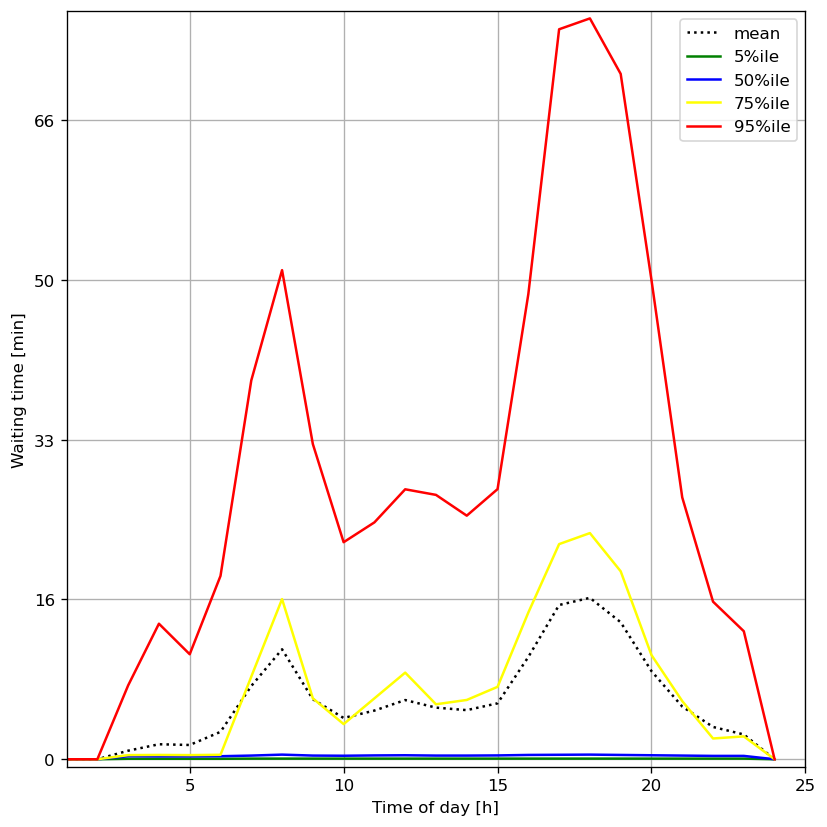

Fig. 2: Passenger wait times for each hour


In [73]:
plt.figure(figsize = (7, 7), dpi = 120)

plt.plot(df_passenger_wait_time["hour"], df_passenger_wait_time["avg"], color = "black", label = "mean", linestyle = ":")
plt.plot(df_passenger_wait_time["hour"], df_passenger_wait_time["5%ile"], color = "green", label = "5%ile")#, linestyle = ":")
plt.plot(df_passenger_wait_time["hour"], df_passenger_wait_time["50%ile"], color = "blue", label = "50%ile")#, linestyle = ":")
plt.plot(df_passenger_wait_time["hour"], df_passenger_wait_time["75%ile"], color = "yellow", label = "75%ile")#, linestyle = ":")
plt.plot(df_passenger_wait_time["hour"], df_passenger_wait_time["95%ile"], color = "red", label = "95%ile")#, linestyle = ":")

plt.xlabel("Time of day [h]")
plt.ylabel("Waiting time [min]")

plt.gca().yaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x/60)
))

plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([1, 25])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc1/passenger_wait_time_sc1.pdf',bbox_inches="tight")
plt.close()
print("Fig. 2: Passenger wait times for each hour")

In [74]:
print("Max temp 95%ile d'attente ", max(df_passenger_wait_time["95%ile"])/60, " min")
print("Max temp 75%ile d'attente ", max(df_passenger_wait_time["75%ile"])/60, " min")
print("Max temp moyen d'attente ", max(df_passenger_wait_time["avg"])/60, " min")
print("Max temp median d'attente ", max(df_passenger_wait_time["50%ile"])/60, " min")
print("Max temp 5%ile d'attente ", max(df_passenger_wait_time["5%ile"])/60, " min")

Max temp 95%ile d'attente  77.25  min
Max temp 75%ile d'attente  23.583333333333332  min
Max temp moyen d'attente  16.831666666666667  min
Max temp median d'attente  0.48333333333333334  min
Max temp 5%ile d'attente  0.06666666666666667  min


**Analyses**


La figure *Fig. 2* presente les temps d'attente moyen (noir en pointillé), median (bleu), 5%ile (vert) et 95%ile (rouge) au cours de la journée :
- Le temps d'attente moyen avoisine les $17$ min pendant le pic du soir (vers 18h), tandisque le 95e percentile depasse une heure. 
- Le reste de la journée, les agents attendent moins d'une quizaine de minutes en moyenne (seuil de tolerence). 

### Vehicle Empty Drive Ratio

In [75]:
vehicle_empty_drive_ratio_file = "%s/ITERS/it.1300/vehicle_empty_drive_ratio.txt" %output_path

In [76]:
df_vehicle_empty_drive_ratio = pd.read_csv(vehicle_empty_drive_ratio_file, sep="	")
df_vehicle_empty_drive_ratio

,hour,fleetAvg,avg,sd,Unnamed: 4,min,2%ile,5%ile,25%ile,50%ile,75%ile,95%ile,98%ile,max
0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0
1,1,0,0,0,NaN,0,0,0,0,0,0,0,0,0
2,2,0,0,0,NaN,0,0,0,0,0,0,0,0,0
3,3,"0,0575","0,0399","0,1630",NaN,"0,000","0,000","0,000","0,000","0,000","0,000","0,493","0,882","1,000"
4,4,"0,1000","0,0513","0,1771",NaN,"0,000","0,000","0,000","0,000","0,000","0,000","0,500","0,825","1,000"
5,5,"0,0853","0,0397","0,1494",NaN,"0,000","0,000","0,000","0,000","0,000","0,000","0,396","0,611","1,000"
6,6,"0,1208","0,0689","0,1990",NaN,"0,000","0,000","0,000","0,000","0,000","0,000","0,513","0,953","1,000"
7,7,"0,2321","0,1515","0,2651",NaN,"0,000","0,000","0,000","0,000","0,000","0,281","0,749","1,000","1,000"
8,8,"0,3277","0,2353","0,3086",NaN,"0,000","0,000","0,000","0,000","0,000","0,467","0,891","1,000","1,000"
9,9,"0,2886","0,1931","0,2893",NaN,"0,000","0,000","0,000","0,000","0,000","0,386","0,824","1,000","1,000"


In [77]:
df_vehicle_empty_drive_ratio.drop('Unnamed: 4', inplace=True, axis=1)

In [78]:
df_vehicle_empty_drive_ratio["avg"] = [str(i).replace(",", ".") for i in df_vehicle_empty_drive_ratio["avg"]]
df_vehicle_empty_drive_ratio["sd"] = [str(i).replace(",", ".") for i in df_vehicle_empty_drive_ratio["sd"]]
df_vehicle_empty_drive_ratio["5%ile"] = [str(i).replace(",", ".") for i in df_vehicle_empty_drive_ratio["5%ile"]]
df_vehicle_empty_drive_ratio["50%ile"] = [str(i).replace(",", ".") for i in df_vehicle_empty_drive_ratio["50%ile"]]
df_vehicle_empty_drive_ratio["95%ile"] = [str(i).replace(",", ".") for i in df_vehicle_empty_drive_ratio["95%ile"]]

df_vehicle_empty_drive_ratio["avg"] = df_vehicle_empty_drive_ratio["avg"].astype(float)
df_vehicle_empty_drive_ratio["5%ile"] = df_vehicle_empty_drive_ratio["5%ile"].astype(float)
df_vehicle_empty_drive_ratio["50%ile"] = df_vehicle_empty_drive_ratio["50%ile"].astype(float)
df_vehicle_empty_drive_ratio["95%ile"] = df_vehicle_empty_drive_ratio["95%ile"].astype(float)

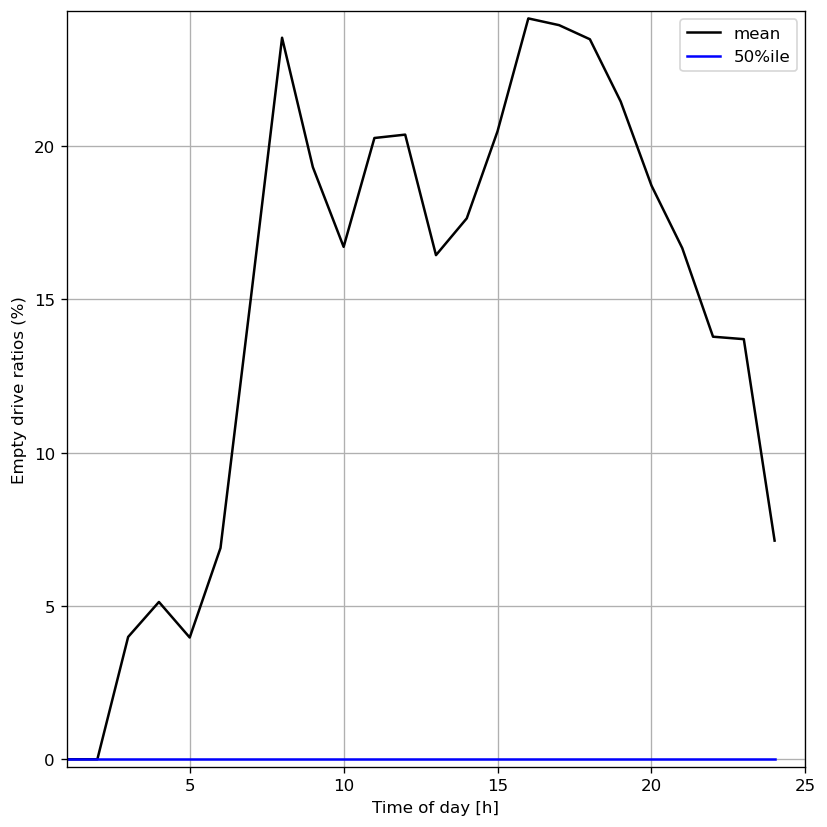

Fig. 3: Empty drive ratios for each hour


In [79]:
plt.figure(figsize = (7, 7), dpi = 120)

plt.plot(df_vehicle_empty_drive_ratio["hour"], df_vehicle_empty_drive_ratio["avg"], color = "black", label = "mean")
#plt.plot(df_vehicle_empty_drive_ratio["hour"], df_vehicle_empty_drive_ratio["5%ile"], color = "green", label = "5%ile")#, linestyle = ":")
plt.plot(df_vehicle_empty_drive_ratio["hour"], df_vehicle_empty_drive_ratio["50%ile"], color = "blue", label = "50%ile")#, linestyle = ":")
#plt.plot(df_vehicle_empty_drive_ratio["hour"], df_vehicle_empty_drive_ratio["95%ile"], color = "red", label = "95%ile")#, linestyle = ":")

plt.xlabel("Time of day [h]")
plt.ylabel("Empty drive ratios (%)")

plt.gca().yaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x * 100)
))


plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([1, 25])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc1/vehicle_empty_drive_ratio_sc1.pdf')
plt.close()
print("Fig. 3: Empty drive ratios for each hour")

**Analyses**


La figure *Fig. 3*  renseigne sur le rapport entre le temps de conduite à vide et le temps total consacré à la conduite.
Durant le pics du matin (8h-9h) et du soir (17h-19h), le ratio est moins de $25\%$ de PAV qui circule à vide. Ce faible ratio se traduit encore par l'allocation des taxis au domicile des agents.

### Vehicle Wait Ratio

In [80]:
vehicle_wait_ratio_file = "%s/ITERS/it.1300/vehicle_wait_ratio.txt" %output_path
df_vehicle_wait_ratio = pd.read_csv(vehicle_wait_ratio_file, sep="	")
df_vehicle_wait_ratio

,hour,fleetAvg,avg,sd,Unnamed: 4,min,2%ile,5%ile,25%ile,50%ile,75%ile,95%ile,98%ile,max
0,0,"1,0000","1,0000","0,0000",NaN,"1,000","1,000","1,000","1,000","1,000","1,000","1,000","1,000","1,000"
1,1,"1,0000","1,0000","0,0000",NaN,"1,000","1,000","1,000","1,000","1,000","1,000","1,000","1,000","1,000"
2,2,"1,0000","1,0000","0,0000",NaN,"1,000","1,000","1,000","1,000","1,000","1,000","1,000","1,000","1,000"
3,3,"0,9996","0,9996","0,0095",NaN,"0,631","1,000","1,000","1,000","1,000","1,000","1,000","1,000","1,000"
4,4,"0,9965","0,9965","0,0310",NaN,"0,113","1,000","1,000","1,000","1,000","1,000","1,000","1,000","1,000"
5,5,"0,9923","0,9923","0,0463",NaN,"0,056","0,843","1,000","1,000","1,000","1,000","1,000","1,000","1,000"
6,6,"0,9744","0,9744","0,0843",NaN,"0,000","0,677","0,792","1,000","1,000","1,000","1,000","1,000","1,000"
7,7,"0,9034","0,9034","0,1858",NaN,"0,000","0,292","0,481","0,881","1,000","1,000","1,000","1,000","1,000"
8,8,"0,8364","0,8364","0,2728",NaN,"0,000","0,000","0,163","0,755","1,000","1,000","1,000","1,000","1,000"
9,9,"0,8982","0,8982","0,2169",NaN,"0,000","0,105","0,368","0,921","1,000","1,000","1,000","1,000","1,000"


In [81]:
df_vehicle_wait_ratio.drop('Unnamed: 4', inplace=True, axis=1)

In [82]:
df_vehicle_wait_ratio["avg"] = [str(i).replace(",", ".") for i in df_vehicle_wait_ratio["avg"]]
df_vehicle_wait_ratio["sd"] = [str(i).replace(",", ".") for i in df_vehicle_wait_ratio["sd"]]
df_vehicle_wait_ratio["5%ile"] = [str(i).replace(",", ".") for i in df_vehicle_wait_ratio["5%ile"]]
df_vehicle_wait_ratio["50%ile"] = [str(i).replace(",", ".") for i in df_vehicle_wait_ratio["50%ile"]]
df_vehicle_wait_ratio["95%ile"] = [str(i).replace(",", ".") for i in df_vehicle_wait_ratio["95%ile"]]

df_vehicle_wait_ratio["avg"] = df_vehicle_wait_ratio["avg"].astype(float)
df_vehicle_wait_ratio["5%ile"] = df_vehicle_wait_ratio["5%ile"].astype(float)
df_vehicle_wait_ratio["50%ile"] = df_vehicle_wait_ratio["50%ile"].astype(float)
df_vehicle_wait_ratio["95%ile"] = df_vehicle_wait_ratio["95%ile"].astype(float)

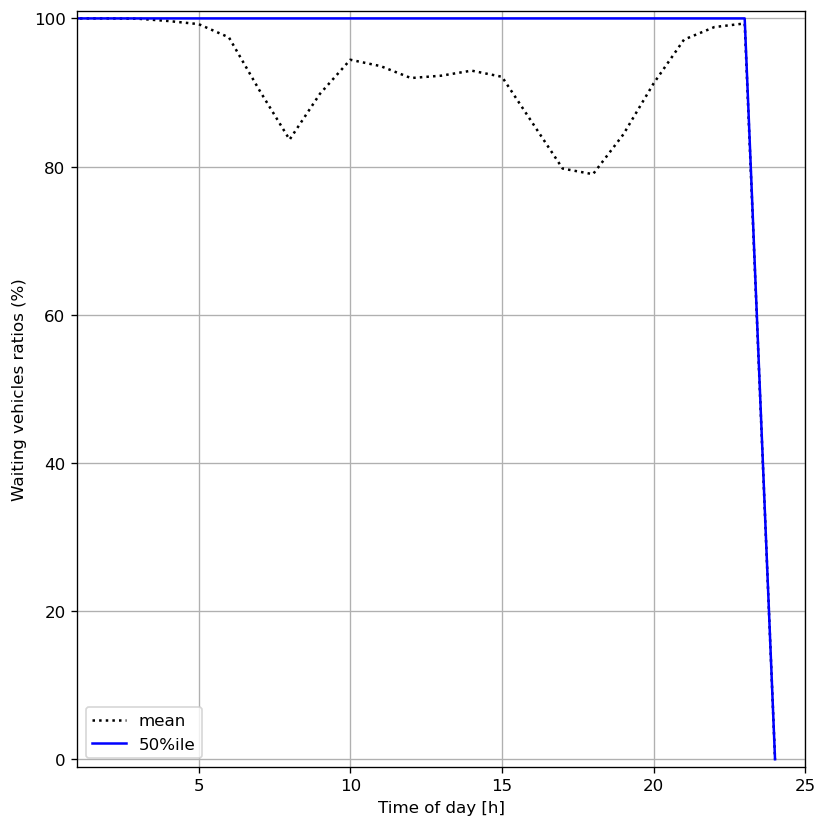

Fig. 4: Waiting vehicles ratios 


In [83]:
plt.figure(figsize = (7, 7), dpi = 120)

plt.plot(df_vehicle_wait_ratio["hour"], df_vehicle_wait_ratio["avg"], color = "black", label = "mean" , linestyle = ":")
#plt.plot(df_vehicle_wait_ratio["hour"], df_vehicle_wait_ratio["5%ile"], color = "green", label = "5%ile")#, linestyle = ":")
plt.plot(df_vehicle_wait_ratio["hour"], df_vehicle_wait_ratio["50%ile"], color = "blue", label = "50%ile")#, linestyle = ":")
#plt.plot(df_vehicle_wait_ratio["hour"], df_vehicle_wait_ratio["95%ile"], color = "red", label = "95%ile")#, linestyle = ":")

plt.xlabel("Time of day [h]")
plt.ylabel("Waiting vehicles ratios (%)")

plt.gca().yaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x * 100)
))


plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([1, 25])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc1/vehicle_wait_ratio_c3.pdf')
plt.close()
print("Fig. 4: Waiting vehicles ratios ")

**Quelques commentaires**

- Le nombre de déplacements en PAV à la fin de la simulation est $82572$ contre $79691$ initialement programés soit une augmentation de 2881 déplacements (environ $4\%$ d'augmentation).
- Cette legère augmentation signifierait que le PAV est plus attractif que les autres autres modes disponibles pour l'agent comme les TC, le vélo ou encore la MAP.

## Output trips cvs analysis for the waiting time checking

In [84]:
trips_file = "%s/sce1.1000_ite.output_trips.csv.gz" %output_path
df_trips_output = pd.read_csv(gzip.open(trips_file,'r'), sep=";")

In [85]:
df_trips_output

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,start_facility_id,start_link,start_x,start_y,end_facility_id,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop
0,1000008,1,1000008_1,06:59:12,00:12:27,00:00:19,4315,2193,NaN,private_AV,...,home_474430,8102,844783.995555,6.519932e+06,sec_27677,50655,842728.100000,6.519167e+06,NaN,NaN
1,1000008,2,1000008_2,07:18:22,00:13:31,00:00:09,9610,7331,NaN,private_AV,...,sec_27677,50655,842728.100000,6.519167e+06,work_263614,51370,841768.160000,6.511899e+06,NaN,NaN
2,1000008,3,1000008_3,12:06:22,00:10:16,00:00:00,740,569,NaN,walk,...,work_263614,51370,841768.160000,6.511899e+06,sec_45586,32552,841455.790000,6.511423e+06,NaN,NaN
3,1000008,4,1000008_4,12:29:55,00:10:16,00:00:00,740,569,NaN,walk,...,sec_45586,32552,841455.790000,6.511423e+06,work_263614,51370,841768.160000,6.511899e+06,NaN,NaN
4,1000008,5,1000008_5,17:22:34,01:53:17,01:04:15,12640,8580,NaN,private_AV,...,work_263614,51370,841768.160000,6.511899e+06,home_474430,8102,844783.995555,6.519932e+06,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230267,999994,2,999994_2,07:10:52,00:05:50,00:00:09,1415,802,NaN,private_AV,...,sec_42480,69858,847968.600000,6.518541e+06,edu_1135,33122,847319.700000,6.519014e+06,NaN,NaN
230268,999994,3,999994_3,16:15:31,01:06:59,00:22:45,15235,7480,NaN,private_AV,...,edu_1135,33122,847319.700000,6.519014e+06,home_474420,17018,854492.550000,6.521136e+06,NaN,NaN
230269,999995,1,999995_1,07:13:37,00:35:04,00:25:22,3605,2768,NaN,private_AV,...,home_474420,17018,854492.550000,6.521136e+06,edu_1164,44221,857259.400000,6.521244e+06,NaN,NaN
230270,999995,2,999995_2,11:28:37,00:09:25,00:00:24,3794,2768,NaN,private_AV,...,edu_1164,44221,857259.400000,6.521244e+06,home_474420,17018,854492.550000,6.521136e+06,NaN,NaN


In [86]:
df_trips_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230272 entries, 0 to 230271
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   person                  230272 non-null  int64  
 1   trip_number             230272 non-null  int64  
 2   trip_id                 230272 non-null  object 
 3   dep_time                230272 non-null  object 
 4   trav_time               230272 non-null  object 
 5   wait_time               230272 non-null  object 
 6   traveled_distance       230272 non-null  int64  
 7   euclidean_distance      230272 non-null  int64  
 8   main_mode               0 non-null       float64
 9   longest_distance_mode   230272 non-null  object 
 10  modes                   230272 non-null  object 
 11  start_activity_type     230272 non-null  object 
 12  end_activity_type       230272 non-null  object 
 13  start_facility_id       230272 non-null  object 
 14  start_link          

In [87]:
df_trips_output.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
person,230272.0,6.290083e+05,363863.916958,4.400000e+01,3.149690e+05,627214.50,944254.000,1262501.0
trip_number,230272.0,2.833275e+00,1.912029,1.000000e+00,1.000000e+00,2.00,4.000,19.0
traveled_distance,230272.0,4.079935e+03,4841.819038,0.000000e+00,7.780000e+02,2163.00,5640.000,48637.0
euclidean_distance,230272.0,2.480571e+03,2968.784248,0.000000e+00,5.610000e+02,1212.00,3443.000,29288.0
main_mode,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_link,230272.0,4.443945e+04,25414.354357,3.000000e+00,2.330500e+04,43846.00,66285.000,88997.0
start_x,230272.0,8.446526e+05,4397.531343,8.317482e+05,8.418326e+05,844517.50,847037.900,859982.0
start_y,230272.0,6.518291e+06,4606.736036,6.497050e+06,6.516376e+06,6519018.14,6520944.325,6539158.2
end_link,230272.0,4.444742e+04,25414.297212,3.000000e+00,2.331500e+04,43850.00,66287.000,88997.0
end_x,230272.0,8.446527e+05,4396.575443,8.317482e+05,8.418333e+05,844518.39,847037.900,859982.0


In [88]:
df_trips_output["dep_time_in_s"] = df_trips_output["dep_time"].apply(convert_time_h_m_s).astype(float)
df_trips_output["trav_time_in_s"] = df_trips_output["trav_time"].apply(convert_time_h_m_s).astype(float)
df_trips_output["wait_time_in_s"] = df_trips_output["wait_time"].apply(convert_time_h_m_s).astype(float)

In [89]:
df_trips_output

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,start_y,end_facility_id,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop,dep_time_in_s,trav_time_in_s,wait_time_in_s
0,1000008,1,1000008_1,06:59:12,00:12:27,00:00:19,4315,2193,NaN,private_AV,...,6.519932e+06,sec_27677,50655,842728.100000,6.519167e+06,NaN,NaN,25152.0,747.0,19.0
1,1000008,2,1000008_2,07:18:22,00:13:31,00:00:09,9610,7331,NaN,private_AV,...,6.519167e+06,work_263614,51370,841768.160000,6.511899e+06,NaN,NaN,26302.0,811.0,9.0
2,1000008,3,1000008_3,12:06:22,00:10:16,00:00:00,740,569,NaN,walk,...,6.511899e+06,sec_45586,32552,841455.790000,6.511423e+06,NaN,NaN,43582.0,616.0,0.0
3,1000008,4,1000008_4,12:29:55,00:10:16,00:00:00,740,569,NaN,walk,...,6.511423e+06,work_263614,51370,841768.160000,6.511899e+06,NaN,NaN,44995.0,616.0,0.0
4,1000008,5,1000008_5,17:22:34,01:53:17,01:04:15,12640,8580,NaN,private_AV,...,6.511899e+06,home_474430,8102,844783.995555,6.519932e+06,NaN,NaN,62554.0,6797.0,3855.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230267,999994,2,999994_2,07:10:52,00:05:50,00:00:09,1415,802,NaN,private_AV,...,6.518541e+06,edu_1135,33122,847319.700000,6.519014e+06,NaN,NaN,25852.0,350.0,9.0
230268,999994,3,999994_3,16:15:31,01:06:59,00:22:45,15235,7480,NaN,private_AV,...,6.519014e+06,home_474420,17018,854492.550000,6.521136e+06,NaN,NaN,58531.0,4019.0,1365.0
230269,999995,1,999995_1,07:13:37,00:35:04,00:25:22,3605,2768,NaN,private_AV,...,6.521136e+06,edu_1164,44221,857259.400000,6.521244e+06,NaN,NaN,26017.0,2104.0,1522.0
230270,999995,2,999995_2,11:28:37,00:09:25,00:00:24,3794,2768,NaN,private_AV,...,6.521244e+06,home_474420,17018,854492.550000,6.521136e+06,NaN,NaN,41317.0,565.0,24.0


### Parts modales

In [90]:
modal_share_out = df_trips_output["longest_distance_mode"].value_counts(normalize=True) * 100

In [91]:
modal_share_out

private_AV    45.074955
walk          31.037208
pt            23.603825
bike           0.284012
Name: longest_distance_mode, dtype: float64

Text(0.5, 0, 'Mode de transport')

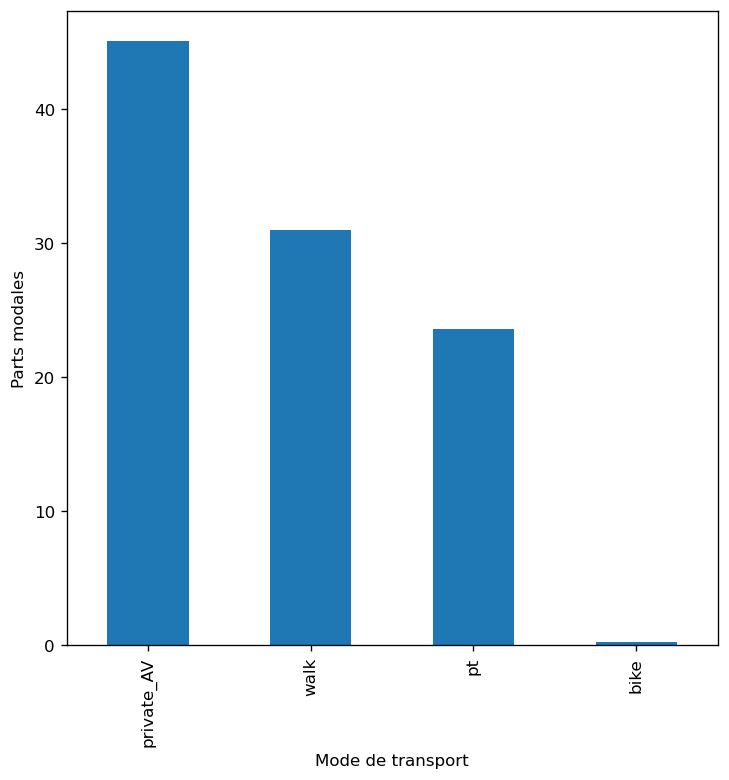

In [92]:
plt.figure(figsize = (7, 7), dpi = 120)
modal_share_out.plot(kind="bar")
plt.ylabel("Parts modales")
plt.xlabel("Mode de transport")

In [93]:
#plt.figure(figsize = (7, 7), dpi = 120)
#ax = sns.countplot(x="longest_distance_mode", data=df_trips_output)
#ax.grid(axis='y')
#plt.ylabel("Nombre de déplacements")
#plt.xlabel("Parts modales à la fin de la simulation")

In [94]:
df_trips_output["dep_time_class"] = np.digitize(df_trips_output["dep_time_in_s"], time_class)

Text(0.5, 0, 'Time [h]')

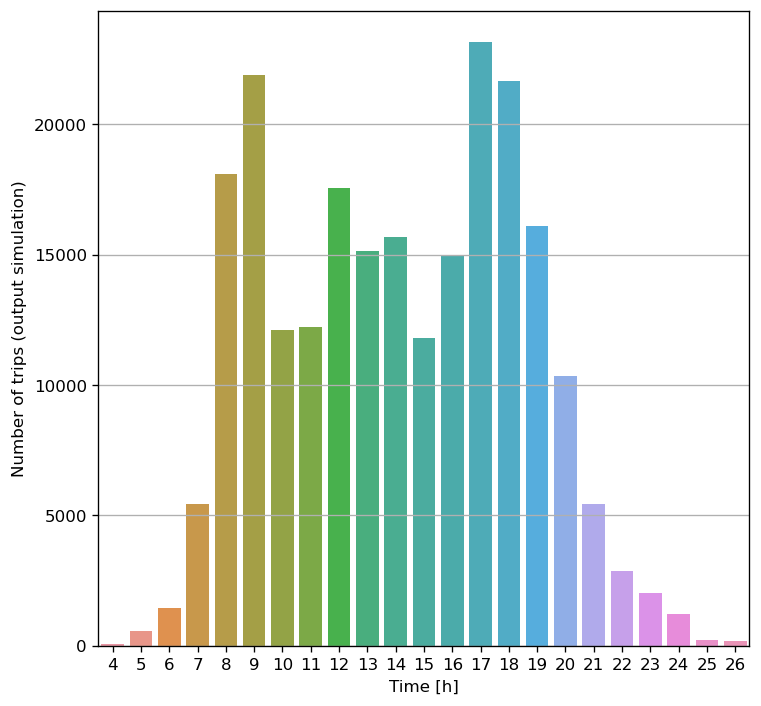

In [95]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="dep_time_class", data=df_trips_output)
ax.grid(axis='y')
plt.ylabel("Number of trips (output simulation)")
plt.xlabel("Time [h]")

In [96]:
df_trips_output_pav = df_trips_output[df_trips_output["longest_distance_mode"]=="private_AV"]
df_trips_output_pav

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,end_facility_id,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop,dep_time_in_s,trav_time_in_s,wait_time_in_s,dep_time_class
0,1000008,1,1000008_1,06:59:12,00:12:27,00:00:19,4315,2193,NaN,private_AV,...,sec_27677,50655,842728.100000,6.519167e+06,NaN,NaN,25152.0,747.0,19.0,7
1,1000008,2,1000008_2,07:18:22,00:13:31,00:00:09,9610,7331,NaN,private_AV,...,work_263614,51370,841768.160000,6.511899e+06,NaN,NaN,26302.0,811.0,9.0,8
4,1000008,5,1000008_5,17:22:34,01:53:17,01:04:15,12640,8580,NaN,private_AV,...,home_474430,8102,844783.995555,6.519932e+06,NaN,NaN,62554.0,6797.0,3855.0,18
5,1000008,6,1000008_6,19:27:22,00:26:52,00:00:09,5801,2978,NaN,private_AV,...,sec_835,4982,842067.600000,6.518710e+06,NaN,NaN,70042.0,1612.0,9.0,20
6,1000008,7,1000008_7,19:54:14,00:22:55,00:00:17,4413,2978,NaN,private_AV,...,home_474430,8102,844783.995555,6.519932e+06,NaN,NaN,71654.0,1375.0,17.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230266,999994,1,999994_1,06:45:31,00:25:21,00:08:21,14500,7020,NaN,private_AV,...,sec_42480,69858,847968.600000,6.518541e+06,NaN,NaN,24331.0,1521.0,501.0,7
230267,999994,2,999994_2,07:10:52,00:05:50,00:00:09,1415,802,NaN,private_AV,...,edu_1135,33122,847319.700000,6.519014e+06,NaN,NaN,25852.0,350.0,9.0,8
230268,999994,3,999994_3,16:15:31,01:06:59,00:22:45,15235,7480,NaN,private_AV,...,home_474420,17018,854492.550000,6.521136e+06,NaN,NaN,58531.0,4019.0,1365.0,17
230269,999995,1,999995_1,07:13:37,00:35:04,00:25:22,3605,2768,NaN,private_AV,...,edu_1164,44221,857259.400000,6.521244e+06,NaN,NaN,26017.0,2104.0,1522.0,8


Text(0.5, 0, 'Time of day [h]')

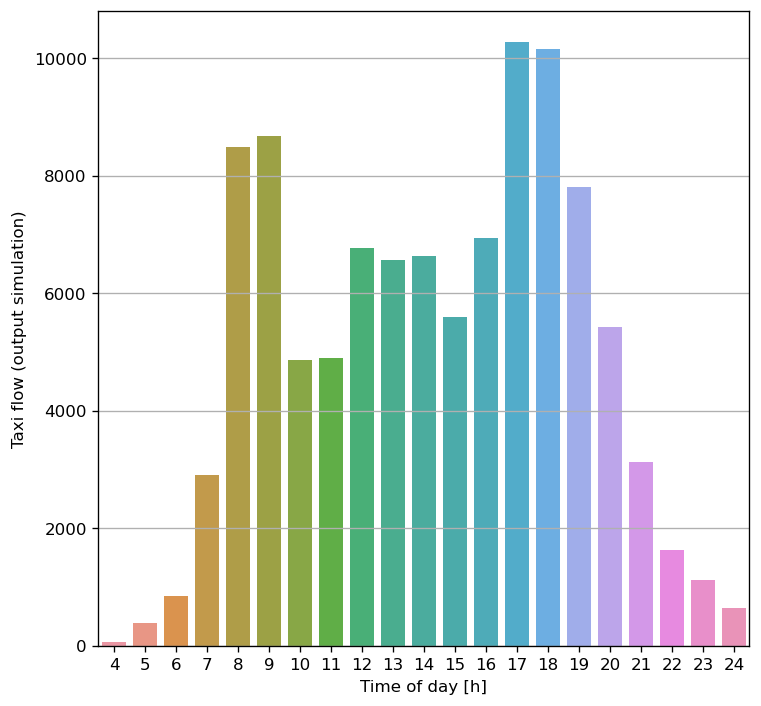

In [97]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="dep_time_class", data=df_trips_output_pav)
ax.grid(axis='y')
plt.ylabel("Taxi flow (output simulation)")
plt.xlabel("Time of day [h]")

In [98]:
modal_share_out

private_AV    45.074955
walk          31.037208
pt            23.603825
bike           0.284012
Name: longest_distance_mode, dtype: float64

In [99]:
modal_share_inp

walk          58.707185
private_AV    22.475076
pt            17.425086
bike           1.392653
Name: mode, dtype: float64

**Analyse**

- Le nombre total de déplacements en PAV passe de $\mathbf{22.47\%}$ (demande initiale) à $\mathbf{40,42\%}$ soit une augmentation de $\mathbf{80\%}$. Cette augmentation se traduit par une diminution des déplacements à pied ($- \mathbf{38,5\%}$ ) et à vélo ($- \mathbf{64,75\%}$ ) au profit des déplacements en PAV.
- La part modal en TC connait également une augmentation de $ \mathbf{32\%}$.

In [100]:
wait_time_class = [0, 300, 600, 900, 1800, 3600, np.inf]

In [101]:
df_trips_output_pav["wait_time_class"] = np.digitize(df_trips_output_pav["wait_time_in_s"], wait_time_class)

/tmp/ipykernel_207359/718653752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trips_output_pav["wait_time_class"] = np.digitize(df_trips_output_pav["wait_time_in_s"], wait_time_class)


Text(0.5, 0, 'Waiting time [min]')

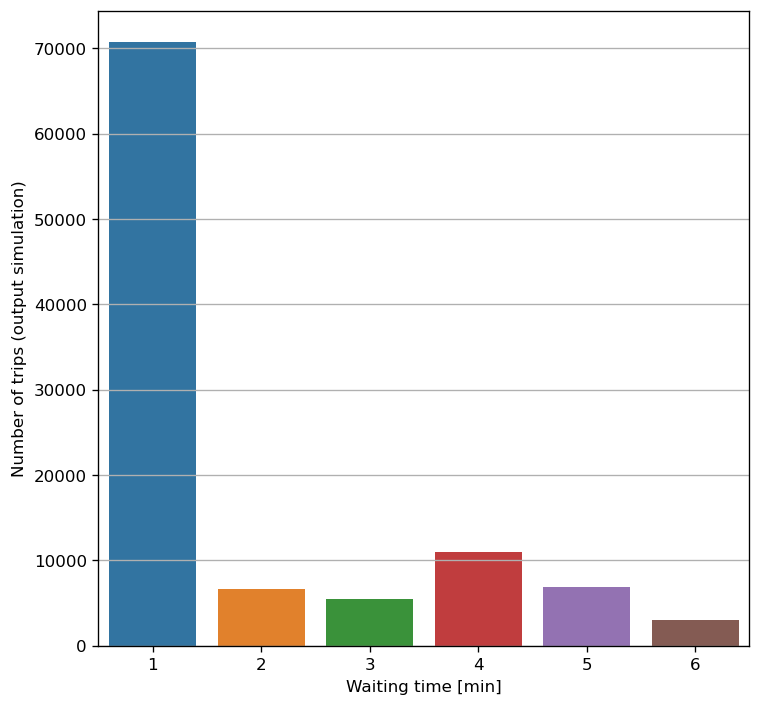

In [102]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="wait_time_class", data=df_trips_output_pav)
ax.grid(axis='y')
plt.ylabel("Number of trips (output simulation)")
plt.xlabel("Waiting time [min]")

In [103]:
#df_wait_mean2 = df_trips_output.groupby("dep_time_class")["wait_time_in_s"].mean().reset_index().rename({ "wait_time_in_s" : "avg" }, axis = 1)

In [104]:
#df_wait_median2 = df_trips_output.groupby("dep_time_class")["wait_time_in_s"].median().reset_index().rename({ "wait_time_in_s" : "median" }, axis = 1)

In [105]:
#waiting mean time by time of day
df_wait_mean = df_trips_output_pav[["dep_time_class", "wait_time_in_s"]].groupby("dep_time_class").mean().reset_index().rename({ "wait_time_in_s" : "avg" }, axis = 1)
#waiting median time by time of day
df_wait_median = df_trips_output_pav[["dep_time_class", "wait_time_in_s"]].groupby("dep_time_class").median().reset_index().rename({ "wait_time_in_s" : "50%ile" }, axis = 1)
#waiting min time by time of day
df_wait_min = df_trips_output_pav[["dep_time_class", "wait_time_in_s"]].groupby("dep_time_class").min().reset_index().rename({ "wait_time_in_s" : "min" }, axis = 1)
#waiting max time by time of day
df_wait_max = df_trips_output_pav[["dep_time_class", "wait_time_in_s"]].groupby("dep_time_class").max().reset_index().rename({ "wait_time_in_s" : "max" }, axis = 1)
#waiting std time by time of day
df_wait_std = df_trips_output_pav[["dep_time_class", "wait_time_in_s"]].groupby("dep_time_class").std().reset_index().rename({ "wait_time_in_s" : "std" }, axis = 1)

In [106]:
##dff = df_trips_output_taxi[["dep_time_class", "wait_time_in_s"]].groupby("dep_time_class").groups 

In [107]:
#waiting 5% time by time of day
#percentile_5 = np.percentile(df_trips_output_pav[["dep_time_class", "wait_time_in_s"]].groupby("dep_time_class").value_counts, 5)

In [108]:
df_wait_time = pd.merge(df_wait_mean, df_wait_median, on = "dep_time_class")

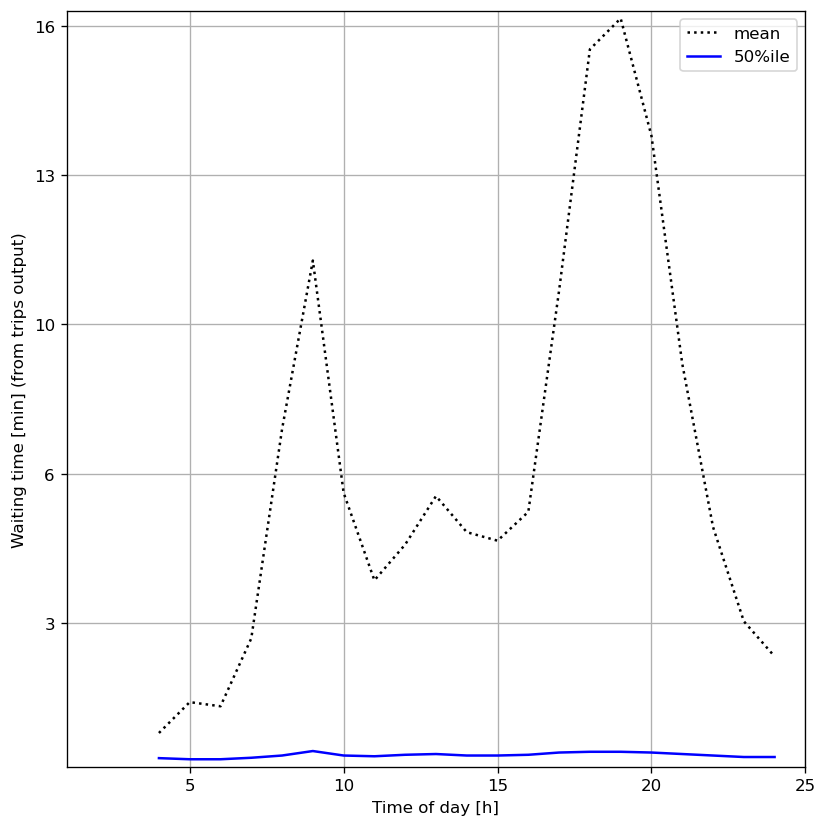

Fig. 6: Passenger wait times for each hour (from trips output)


In [109]:
plt.figure(figsize = (7, 7), dpi = 120)

plt.plot(df_wait_time["dep_time_class"], df_wait_time["avg"], color = "black", label = "mean", linestyle = ":")
plt.plot(df_wait_time["dep_time_class"], df_wait_time["50%ile"], color = "blue", label = "50%ile")#, linestyle = ":")

plt.xlabel("Time of day [h]")
plt.ylabel("Waiting time [min] (from trips output)")

plt.gca().yaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x/60)
))

plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([1, 25])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc2/trips_ouput_passenger_wait_time_c2.pdf')
plt.close()
print("Fig. 6: Passenger wait times for each hour (from trips output)")

#### Plus de 30 min d'attente

In [110]:
df_trips_output_pav_wait_30 = df_trips_output_pav[df_trips_output_pav["wait_time_in_s"]>= 1800]

In [111]:
df_trips_output_pav_wait_30

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop,dep_time_in_s,trav_time_in_s,wait_time_in_s,dep_time_class,wait_time_class
4,1000008,5,1000008_5,17:22:34,01:53:17,01:04:15,12640,8580,NaN,private_AV,...,8102,844783.995555,6.519932e+06,NaN,NaN,62554.0,6797.0,3855.0,18,6
11,1000010,1,1000010_1,07:41:45,01:08:14,00:41:10,3894,2522,NaN,private_AV,...,15949,847012.540000,6.518749e+06,NaN,NaN,27705.0,4094.0,2470.0,8,5
25,100003,1,100003_1,07:47:25,00:43:08,00:35:16,2089,1472,NaN,private_AV,...,44281,847415.340000,6.512925e+06,NaN,NaN,28045.0,2588.0,2116.0,8,5
62,1000096,1,1000096_1,07:23:54,00:47:33,00:34:46,2090,1889,NaN,private_AV,...,79949,840307.540000,6.520854e+06,NaN,NaN,26634.0,2853.0,2086.0,8,5
63,1000096,2,1000096_2,13:08:54,00:46:42,00:41:30,2910,1889,NaN,private_AV,...,9438,840998.550000,6.519095e+06,NaN,NaN,47334.0,2802.0,2490.0,14,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230206,999523,2,999523_2,17:57:35,00:43:16,00:31:56,5725,3790,NaN,private_AV,...,85509,838650.550000,6.517646e+06,NaN,NaN,64655.0,2596.0,1916.0,18,5
230220,999612,2,999612_2,18:02:28,01:29:36,00:44:42,25992,10221,NaN,private_AV,...,68332,848380.000000,6.527980e+06,NaN,NaN,64948.0,5376.0,2682.0,19,5
230223,999613,1,999613_1,14:42:56,00:44:43,00:38:13,3443,2475,NaN,private_AV,...,29263,846505.250000,6.526363e+06,NaN,NaN,52976.0,2683.0,2293.0,15,5
230225,999613,3,999613_3,18:15:08,01:44:14,01:29:48,6695,4455,NaN,private_AV,...,68332,848380.000000,6.527980e+06,NaN,NaN,65708.0,6254.0,5388.0,19,6


#### Plus d'une heure d'attente

In [112]:
df_trips_output_pav_wait_60 = df_trips_output_pav[df_trips_output_pav["wait_time_in_s"]>= 3600]

In [113]:
df_trips_output_pav_wait_60

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop,dep_time_in_s,trav_time_in_s,wait_time_in_s,dep_time_class,wait_time_class
4,1000008,5,1000008_5,17:22:34,01:53:17,01:04:15,12640,8580,NaN,private_AV,...,8102,844783.995555,6.519932e+06,NaN,NaN,62554.0,6797.0,3855.0,18,6
169,1000333,2,1000333_2,12:10:44,01:04:34,01:00:58,1163,725,NaN,private_AV,...,9830,850865.070000,6.510907e+06,NaN,NaN,43844.0,3874.0,3658.0,13,6
170,1000333,3,1000333_3,16:51:11,01:24:00,01:09:13,4399,2832,NaN,private_AV,...,78593,848785.760000,6.508984e+06,NaN,NaN,60671.0,5040.0,4153.0,17,6
173,1000333,6,1000333_6,18:47:35,01:36:49,01:31:24,3680,1064,NaN,private_AV,...,68926,852905.520000,6.511174e+06,NaN,NaN,67655.0,5809.0,5484.0,19,6
193,1000337,2,1000337_2,14:27:51,01:15:40,01:03:54,5341,3379,NaN,private_AV,...,9830,850865.070000,6.510907e+06,NaN,NaN,52071.0,4540.0,3834.0,15,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229978,997911,2,997911_2,16:05:23,02:20:51,01:18:12,11312,8544,NaN,private_AV,...,79232,836523.310000,6.520536e+06,NaN,NaN,57923.0,8451.0,4692.0,17,6
230155,99924,5,99924_5,18:48:33,01:30:57,01:21:04,6196,4292,NaN,private_AV,...,64408,840557.110000,6.524742e+06,NaN,NaN,67713.0,5457.0,4864.0,19,6
230163,99925,7,99925_7,18:33:01,01:14:18,01:06:59,2790,2144,NaN,private_AV,...,24487,835886.050000,6.518998e+06,NaN,NaN,66781.0,4458.0,4019.0,19,6
230225,999613,3,999613_3,18:15:08,01:44:14,01:29:48,6695,4455,NaN,private_AV,...,68332,848380.000000,6.527980e+06,NaN,NaN,65708.0,6254.0,5388.0,19,6


#### Plus de deux heures d'attente

In [114]:
df_trips_output_pav[df_trips_output_pav["wait_time_in_s"]>= 7200]

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop,dep_time_in_s,trav_time_in_s,wait_time_in_s,dep_time_class,wait_time_class
834,100428,6,100428_6,17:57:00,03:05:34,02:55:54,4736,2410,NaN,private_AV,...,19177,849638.15,6517972.32,NaN,NaN,64620.0,11134.0,10554.0,18,6
1319,1006390,4,1006390_4,18:18:55,03:08:57,02:47:39,12043,8578,NaN,private_AV,...,49680,845524.08,6518442.13,NaN,NaN,65935.0,11337.0,10059.0,19,6
1323,1006391,2,1006391_2,18:48:29,03:26:54,03:04:51,9991,7274,NaN,private_AV,...,49680,845524.08,6518442.13,NaN,NaN,67709.0,12414.0,11091.0,19,6
2274,1010426,1,1010426_1,07:31:32,02:51:43,02:30:33,4779,3454,NaN,private_AV,...,44535,843811.76,6519884.68,NaN,NaN,27092.0,10303.0,9033.0,8,6
2732,1013028,5,1013028_5,17:19:42,02:56:28,02:20:16,15116,6975,NaN,private_AV,...,68347,848392.90,6528324.80,NaN,NaN,62382.0,10588.0,8416.0,18,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224182,968739,2,968739_2,19:19:53,03:19:43,03:10:16,1925,1199,NaN,private_AV,...,33367,846657.49,6524757.40,NaN,NaN,69593.0,11983.0,11416.0,20,6
224187,968740,5,968740_5,18:46:58,02:55:59,02:39:58,4325,3123,NaN,private_AV,...,33367,846657.49,6524757.40,NaN,NaN,67618.0,10559.0,9598.0,19,6
224513,970063,5,970063_5,18:16:51,02:38:51,02:12:26,16105,11768,NaN,private_AV,...,20787,839743.92,6521305.07,NaN,NaN,65811.0,9531.0,7946.0,19,6
227372,984629,1,984629_1,08:13:37,02:11:00,02:02:06,2055,1157,NaN,private_AV,...,42911,844108.70,6520102.70,NaN,NaN,29617.0,7860.0,7326.0,9,6


#### Plus de trois heures d'attente

In [115]:
df_trips_output_pav[df_trips_output_pav["wait_time_in_s"]>= 10800]

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop,dep_time_in_s,trav_time_in_s,wait_time_in_s,dep_time_class,wait_time_class
1323,1006391,2,1006391_2,18:48:29,03:26:54,03:04:51,9991,7274,NaN,private_AV,...,49680,845524.08,6518442.13,NaN,NaN,67709.0,12414.0,11091.0,19,6
11636,1057623,2,1057623_2,16:29:35,03:55:30,03:33:26,11351,7644,NaN,private_AV,...,47380,840253.07,6518118.84,NaN,NaN,59375.0,14130.0,12806.0,17,6
24725,1122888,2,1122888_2,17:02:27,03:44:08,03:00:49,21129,19256,NaN,private_AV,...,39815,837680.91,6502140.11,NaN,NaN,61347.0,13448.0,10849.0,18,6
26079,1128670,4,1128670_4,17:33:23,03:28:20,03:19:27,2571,1127,NaN,private_AV,...,20643,845135.72,6519207.19,NaN,NaN,63203.0,12500.0,11967.0,18,6
39287,1192013,5,1192013_5,16:28:03,03:20:53,03:02:59,2341,1080,NaN,private_AV,...,69850,847776.60,6518658.60,NaN,NaN,59283.0,12053.0,10979.0,17,6
55042,135392,6,135392_6,17:01:47,03:52:25,03:06:08,11336,7646,NaN,private_AV,...,3786,847085.65,6512016.78,NaN,NaN,61307.0,13945.0,11168.0,18,6
58721,15213,4,15213_4,17:43:53,03:25:49,03:22:28,1768,692,NaN,private_AV,...,44751,846613.04,6524726.19,NaN,NaN,63833.0,12349.0,12148.0,18,6
95212,332490,6,332490_6,17:41:11,03:16:21,03:02:54,8486,6945,NaN,private_AV,...,5253,849640.61,6523062.37,NaN,NaN,63671.0,11781.0,10974.0,18,6
95216,332492,2,332492_2,17:55:35,03:57:17,03:30:27,15942,11807,NaN,private_AV,...,5253,849640.61,6523062.37,NaN,NaN,64535.0,14237.0,12627.0,18,6
95222,332494,4,332494_4,18:22:05,03:40:56,03:37:53,1918,793,NaN,private_AV,...,56946,850110.74,6522343.61,NaN,NaN,66125.0,13256.0,13073.0,19,6


## Investigation des agents qui ont un temps d'attente trop important à partir des plans d'entrée/sortie (cas de la personne $1006391$ par exemple)

### Input plan

In [116]:
df_private_persons_input

,Unnamed: 0,age,bikeAvailability,carAvailability,censusHouseholdId,censusPersonId,employed,hasLicense,hasPtSubscription,householdId,householdIncome,htsHouseholdId,htsPersonId,isPassenger,sex,subpopulation,person_id,number_of_trips,number_of_persons
0,0,32,none,none,183012,377986,True,yes,False,474430,4476.391583,8484,18514,False,m,private,1000008,7,3
1,1,32,all,none,183012,377986,True,yes,False,474430,4476.391583,1537,3356,False,m,private,1000009,4,3
2,2,32,some,none,183012,377986,True,yes,False,474430,4476.391583,4923,10846,True,m,private,1000010,11,3
3,3,33,none,none,18480,38075,False,yes,True,47644,2083.709401,8999,19603,False,m,private,100002,11,3
4,4,33,all,none,18480,38075,False,yes,False,47644,2083.709401,1830,3991,False,m,private,100003,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63165,63165,66,none,none,182997,377959,True,yes,False,474396,3022.192917,680,1540,False,f,private,999947,6,2
63166,63166,25,none,none,183008,377980,False,yes,False,474420,4924.560292,535,1230,False,m,private,999992,2,4
63167,63167,25,none,none,183008,377980,False,no,True,474420,4924.560292,7535,16468,False,m,private,999993,6,4
63168,63168,23,none,none,183008,377981,False,yes,False,474420,4924.560292,3375,7270,False,f,private,999994,3,4


In [117]:
df_persons_input_1006391 = df_persons_input[df_persons_input["person_id"] == 1006391]
df_persons_input_1006391

,Unnamed: 0,age,bikeAvailability,carAvailability,censusHouseholdId,censusPersonId,employed,hasLicense,hasPtSubscription,householdId,householdIncome,htsHouseholdId,htsPersonId,isPassenger,sex,subpopulation,person_id,number_of_trips,number_of_persons
359,359,43,some,none,184194,380397,True,yes,False,477497,6326.530965,1629,3526,False,f,private,1006391,6,4


In [118]:
stop

NameError: name 'stop' is not defined

#### Recherche des personnes appartenant au meme menage

In [ ]:
household_of_1006391 = df_persons_input[df_persons_input["householdId"] == 477497]

In [ ]:
household_of_1006391

#### Recherche des déplacements du menage

In [ ]:
household_of_1006391_person_id = household_of_1006391["person_id"].values

In [ ]:
df_trips_household_of_1006391 = df_trips_input[df_trips_input["person_id"].isin(household_of_1006391_person_id)]

In [ ]:
df_trips_household_of_1006391

In [ ]:
df_trips_household_of_1006391[df_trips_household_of_1006391["mode"]=="private_AV"]

In [ ]:
df_trips_household_of_1006391[df_trips_household_of_1006391["person_id"]==1006391]

In [ ]:
#### Output trips

In [ ]:
df_trips_household_of_1048231_ouput = df_trips_output[df_trips_output["person"].isin(household_of_1048231_person_id)]

In [ ]:
df_trips_household_of_1048231_ouput

In [ ]:
df_trips_household_of_1048231_ouput[df_trips_household_of_1048231_ouput["longest_distance_mode"]=="private_AV"].sort_values("dep_time_in_s")

**Analyse**

- On peut voir que le temps d'attente est lié à la disponibilité du PAV dans le menage. En ffet, lorsqu'un individu du menage utilise le PAV, il n'est plus possible à un autre d'utiliser ce mode. Ainsi, cet individu ne peut qu'attendre la liberarion du PAV pour realiser son déplacement.
- Le temps d'attente impacte sur la durée du déplacement et entraine un effet de chaines sur l'ensemble des déplacements du menage. 

In [ ]:
stop

# Output events analysis

In [ ]:
def events_stats(events):
    number=len(events)
    print("Number of events :   ",number)
    PassengerRequestSubmitted = len([event for event in events.iter('event') if event.attrib["type"]=="PassengerRequest submitted"])
    print("PassengerRequest submitted :", PassengerRequestSubmitted)
    PassengerRequestScheduled = len([event for event in events.iter('event') if event.attrib["type"]=="PassengerRequest scheduled"])
    print("PassengerRequest scheduled :", PassengerRequestScheduled)
    print("PassengerRequest not performed :", PassengerRequestSubmitted - PassengerRequestScheduled)
    pickupTask = len([event for event in events.iter('event') if event.attrib["type"]=="dvrpTaskStarted" and event.attrib["taskType"]=="PICKUP"])
    print("Number of pickup :", pickupTask)
    dropoffTask = len([event for event in events.iter('event') if event.attrib["type"]=="dvrpTaskStarted" and event.attrib["taskType"]=="DROPOFF"])
    print("Number of dropoff :", dropoffTask)
    occupiedDrive = len([event for event in events.iter('event') if event.attrib["type"]=="dvrpTaskStarted" and event.attrib["taskType"]=="OCCUPIED_DRIVE"])
    print("Number of occupied driving :", occupiedDrive)
    emptyDrive = len([event for event in events.iter('event') if event.attrib["type"]=="dvrpTaskStarted" and event.attrib["taskType"]=="EMPTY_DRIVE"])
    print("Number of empty driving :", emptyDrive)

In [ ]:
#<event time="26028.0" type="dvrpTaskStarted" person="TAX40141" link="50655" dvrpVehicle="TAX40141" taskType="PICKUP" taskIndex="6" dvrpMode="taxi"  />

In [ ]:
tree_events = ET.parse(gzip.open("%s/sce1.1000_ite.output_events.xml.gz" % output_path,'r'))
events  = tree_events.getroot()

In [ ]:
#events_stats(events)

In [ ]:
#rdvrpTaskStarted
time = []
person = []
link = []
dvrpVehicle = []
taskType = []

In [ ]:
for event in events.iter('event'):
    if event.attrib["type"]=="dvrpTaskStarted":
        time.append(event.attrib["time"])
        person.append(event.attrib["person"])
        link.append(event.attrib["link"])
        dvrpVehicle.append(event.attrib["dvrpVehicle"])
        taskType.append(event.attrib["taskType"])

In [ ]:
df_taskType = pd.DataFrame({"time":time, "person":person, "link": link, "dvrpVehicle" : dvrpVehicle, "taskType" : taskType})

In [ ]:
df_taskType

In [ ]:
df_taskType.to_csv("%s/df_taskType_PAV.csv" % output_path)

In [ ]:
df_taskType_pick= df_taskType[df_taskType["taskType"]=="PICKUP"]

In [ ]:
df_nb_pick_vh = df_taskType_pick.groupby(["dvrpVehicle"])["taskType"].count().reset_index(name = "number_of_pickups")

In [ ]:
df_nb_pick_vh

In [ ]:
df_nb_pick_vh.describe()

In [ ]:
20510 - 18378

**Commentaire**

- Il y a potentiellement $\mathbf{20510 - 18378 = 2132}$ PAV qui n'ont pas effectué des opérations de recupérations des individus. 
- En moyenne, un PAV a effectué $\mathbf{5}$ embarcations.
- Le nombre minimum d'embarcations est de $\mathbf{1}$ contre $\mathbf{34}$ comme maximum. 

In [ ]:
To do :
    Cherche la cause de la non utilisation des PAV